# 🩺 Phát hiện viêm phổi sử dụng mạng nơ ron tích chập CNN (PyTorch)

Chuẩn đoán bằng hình ảnh là phương pháp phổ biến để phát hiện bệnh. Tuy nhiên, ở một số vùng khó quan sát, việc chuẩn đoán của bác sĩ và các thiết bị chuẩn đoán vẫn còn nhiều hạn chế.


Chúng tôi đã xây dựng một ứng dụng AI sử dụng mạng nơ-ron tích chập **Convolutional Neural Network** để hỗ trợ việc phân tích ảnh X-quang nhanh tróng và chính xác hơn


Chúng ta sẽ bắt đầu chuẩn bị dữ liệu, từng bước xây dựng mô hình, huấn huyện và chiển khai nó

# 📂 Step 1: Tải tập dữ liệu Chest X-Ray Pneumonia

Chúng ta sẽ sử dụng bộ dữ liệu **Chest X-Ray Pneumonia** từ Kaggle.  

Bộ dữ liệu này bao gồm các ảnh X-quang ngực được đánh nhãn **NORMAL** hoặc **PNEUMONIA**


In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mrfantastic003
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia


100%|██████████| 2.29G/2.29G [00:31<00:00, 79.1MB/s]


# 🛠 Step 2: Cài đặt 1 số thư viện cần thiết

Chúng ta sẽ sử dụng 1 số thư viện thiết yếu sau:

- **os / cv2** → file handling & image preprocessing  
- **numpy** → numerical operations  
- **tqdm** → progress tracking  
- **Counter** → quick class frequency counts  
- **matplotlib / seaborn** → data visualization  
- **sklearn** → dataset splitting  

👉Những thư viện này sẽ giúp xây dựng pipeline tiền xử lý dữ liệu

In [3]:
import os  # for file/directory operations
import cv2  # computer vision library for image processing
import numpy as np  # array operations and math functions
import random  # for shuffling and sampling
from tqdm import tqdm  # to visualize long-running operations
from collections import Counter  # for counting frequency of elements
import matplotlib.pyplot as plt  # for creating graphs and charts
import seaborn as sns  # enhanced plotting with better aesthetics
from sklearn.model_selection import train_test_split  # for splitting data into train/test sets
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score


# 📊 Step 3: Tổ chức lại tập dữ liệu

Vì tập dữ liệu **Chest X-Ray Pneumonia** từ Kaggle chứa các tập dữ liệu không đồng đều

Chúng ta sẽ tái cấu trúc tập dữ liệu thành **train / validation / test**.

- Training: 80%  
- Validation: 10%  
- Testing: 10%  

Mỗi tập có tập con là `NORMAL` và `PNEUMONIA`.  

👉 Đảm bảo một quy trình đào tạo và đánh giá rõ ràng.


In [4]:
# Paths
INPUT_DIR = "/content/chest-xray-pneumonia/chest_xray/chest_xray"
OUTPUT_DIR = "/content/chest_xray_split"
SPLITS = ["train", "val", "test"]

# Tập hợp tất cả ảnh theo từng thư mục gốc
images_by_class = {}

for split in SPLITS:
    split_path = os.path.join(INPUT_DIR, split)
    for class_name in ["NORMAL", "PNEUMONIA"]:
        class_path = os.path.join(split_path, class_name)
        if os.path.exists(class_path):
            images_by_class[f"{split}_{class_name}"] = [
                os.path.join(class_path, f) for f in os.listdir(class_path)
                if f.lower().endswith((".jpg", ".jpeg", ".png"))
            ]

### In ra số lượng ảnh theo từng thư mục
for key, files in images_by_class.items():
    print(f"{key}: {len(files)} images")

# Làm phẳng các thư mục ảnh, chia ảnh thành 2 mục là "normal" và "pneumonia"
all_normal_files = []
all_pneumonia_files = []

for key, files in images_by_class.items():
    if "NORMAL" in key:
        all_normal_files.extend(files)
    elif "PNEUMONIA" in key:
        all_pneumonia_files.extend(files)

print(f"\nTotal NORMAL: {len(all_normal_files)}")
print(f"Total PNEUMONIA: {len(all_pneumonia_files)}")

# Tạo thư mục đầu ra theo cấu trúc đã xác định
for split in SPLITS:
    for label in ["NORMAL", "PNEUMONIA"]:
        os.makedirs(os.path.join(OUTPUT_DIR, split, label), exist_ok=True)

# Chia tập dữ liệu thành các tập để huấn luyện (80% train, 10% val, 10% test)
def split_and_save(file_list, class_name):
    train_files, temp_files = train_test_split(file_list, test_size=0.2, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

    split_dict = {
        "train": train_files,
        "val": val_files,
        "test": test_files
    }

    for split, files in split_dict.items():
        for filepath in tqdm(files, desc=f"Saving {split}/{class_name}"):
            img = cv2.imread(filepath)
            if img is None:
                continue
            filename = os.path.basename(filepath)
            save_path = os.path.join(OUTPUT_DIR, split, class_name, filename)
            cv2.imwrite(save_path, img)

# Process each class
split_and_save(all_normal_files, "NORMAL")
split_and_save(all_pneumonia_files, "PNEUMONIA")

print()
print("✅ Dataset saved in:", OUTPUT_DIR)


train_NORMAL: 1341 images
train_PNEUMONIA: 3875 images
val_NORMAL: 8 images
val_PNEUMONIA: 8 images
test_NORMAL: 234 images
test_PNEUMONIA: 390 images

Total NORMAL: 1583
Total PNEUMONIA: 4273


Saving test/PNEUMONIA: 100%|██████████| 428/428 [00:03<00:00, 120.58it/s]


✅ Dataset saved in: /content/chest_xray_split


## Như chúng ta có thể thấy ở output trên 👆, chúng ta có tổng cộng **5856** ảnh cho tập dữ liệu này ( **1538** Normal, **4273** Pneumonia )

# 🔍 Step 4: Tải và xử lý ảnh

Mỗi bức ảnh thực hiện theo các bước sau:

1. Chuyển đổi về dạng **Đen trắng**.
2. Chuyển kích cỡ về **224 × 224 pixels** (kích thức chuẩn).  
3. Chuẩn hóa giá trị pixel trong đoạn **[0,1]**.  
4. Mở rộng kích thước để phù hợp với định dạng đầu vào PyTorch.  

Nhãn được đánh như sau:  
- `0 = NORMAL`  
- `1 = PNEUMONIA`


In [5]:

# Define the root directory that contains the split folders
ROOT_DIR = "/content/chest_xray_split"

# Keep track of the splits you want to load
SPLITS = ["train", "val", "test"]

# Map string labels to integers for model-friendly targets
LABEL_MAP = {"NORMAL": 0, "PNEUMONIA": 1}

def load_split(split_name, target_size=(224, 224), normalize=True):
    """
    Read every image inside ROOT_DIR / split_name / class_label,
    convert it to grayscale, resize, normalize (optional),
    expand the channel dimension, and return the images with labels.
    """
    images = []
    labels = []
    bad_files = []

    # Build the split path
    split_path = os.path.join(ROOT_DIR, split_name)

    for class_name, class_index in LABEL_MAP.items():
        class_path = os.path.join(split_path, class_name)
        if not os.path.exists(class_path):
            continue

        # Iterate through files in the class folder
        for filename in os.listdir(class_path):
            image_path = os.path.join(class_path, filename)

            # Get file extension safely
            _, ext = os.path.splitext(filename)
            if ext.lower() not in {".jpg", ".jpeg", ".png"}:
                continue

            # Read the image directly in grayscale
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                bad_files.append(image_path)
                continue

            # Resize to a fixed target size
            if target_size is not None:
                img = cv2.resize(img, target_size)

            # Normalize pixel values (0–1 range)
            if normalize:
                img = img.astype("float32") / 255.0

            # Expand channel axis to (H, W, 1)
            img = np.expand_dims(img, axis=-1)

            images.append(img)
            labels.append(class_index)

    if bad_files:
        print(f"[WARNING] Skipped {len(bad_files)} corrupted files in '{split_name}'")

    return images, labels


# Load every split using the reusable function
x_train, y_train = load_split("train")
x_val, y_val     = load_split("val")
x_test, y_test   = load_split("test")

# Convert lists to NumPy arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_val,   y_val   = np.array(x_val),   np.array(y_val)
x_test,  y_test  = np.array(x_test),  np.array(y_test)

# Display the dataset stats
print(f"Train set: {x_train.shape}, labels: {y_train.shape}")
print(f"Validation set: {x_val.shape}, labels: {y_val.shape}")
print(f"Test set: {x_test.shape}, labels: {y_test.shape}")

# Show class balance
print("Class balance in train:", Counter(y_train))
print("Class balance in val:  ", Counter(y_val))
print("Class balance in test: ", Counter(y_test))


Train set: (4684, 224, 224, 1), labels: (4684,)
Validation set: (585, 224, 224, 1), labels: (585,)
Test set: (587, 224, 224, 1), labels: (587,)
Class balance in train: Counter({np.int64(1): 3418, np.int64(0): 1266})
Class balance in val:   Counter({np.int64(1): 427, np.int64(0): 158})
Class balance in test:  Counter({np.int64(1): 428, np.int64(0): 159})


# 👀 Step 5: Trực quan hóa ảnh mẫu

Để xác định quá trình tiền xử lý có chính xác không, chúng ta phát họa 1 số ảnh ngẫu nhiên từ toàn bộ ảnh đã xử lý:  

- Ảnh X-quang (Đen trắng)  
- **Nhãn** của ảnh đó (Normal or Pneumonia)  
- Chiều của ảnh  


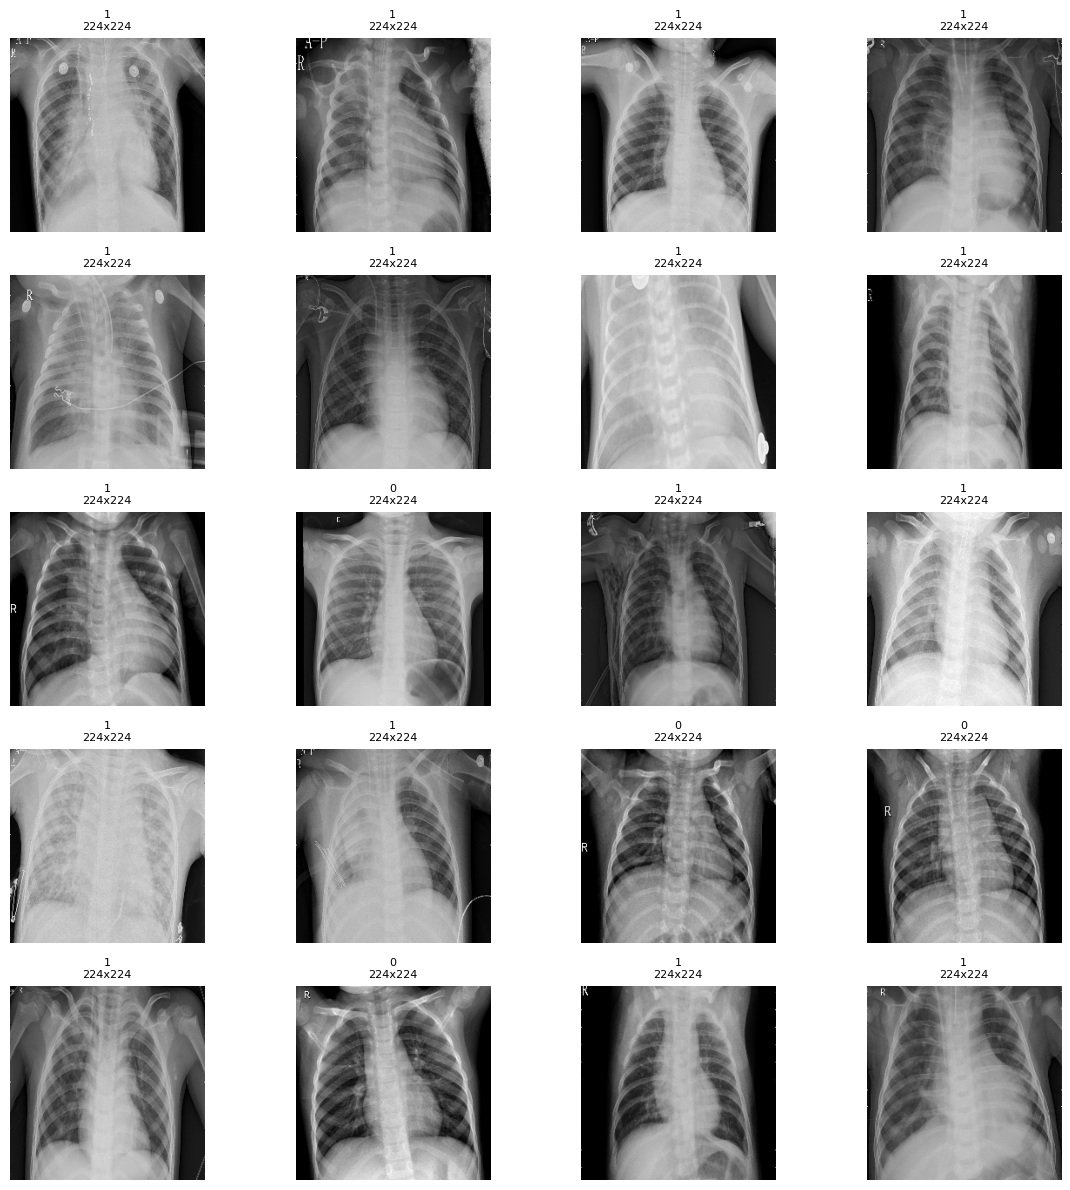

In [6]:


# Chọn 20 ảnh ngẫu nhiên
indices = random.sample(range(len(x_train)), 20)

plt.figure(figsize=(12, 12))

for i, idx in enumerate(indices):
    plt.subplot(5, 4, i + 1)
    plt.imshow(x_train[idx], cmap='gray')
    img_shape = x_train[idx].shape
    plt.title(f"{ y_train[idx]}\n{img_shape[0]}x{img_shape[1]}", fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()


### Nhìn vào các cạnh của tập huấn luyện, test, valid

In [7]:
print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of x_val: {x_val.shape}")
print(f"Shape of y_val: {y_val.shape}")
print(f"Shape of x_test: {x_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of x_train: (4684, 224, 224, 1)
Shape of y_train: (4684,)
Shape of x_val: (585, 224, 224, 1)
Shape of y_val: (585,)
Shape of x_test: (587, 224, 224, 1)
Shape of y_test: (587,)


Những cạnh này không khớp với cạnh của Pytorch mong muốn

# 🔄 Step 6: Chuyển dữ liệu thành PyTorch Tensors

Chúng ta chuyển mảng numpy thành **PyTorch tensors**.

- Cạnh sẽ theo thứ tự từ `(N, H, W, C)` → `(N, C, H, W)`  
- Điều này phù hợp với quy ước của PyTorch: **channel-first format**  



In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as transforms

# Convert your existing NumPy arrays to PyTorch tensors
x_train_tensor = torch.FloatTensor(x_train).permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)
y_train_tensor = torch.LongTensor(y_train)

x_val_tensor = torch.FloatTensor(x_val).permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)
y_val_tensor = torch.LongTensor(y_val)

x_test_tensor = torch.FloatTensor(x_test).permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)
y_test_tensor = torch.LongTensor(y_test)

print(f"Train: {x_train_tensor.shape}, {y_train_tensor.shape}")
print(f"Val: {x_val_tensor.shape}, {y_val_tensor.shape}")
print(f"Test: {x_test_tensor.shape}, {y_test_tensor.shape}")

Train: torch.Size([4684, 1, 224, 224]), torch.Size([4684])
Val: torch.Size([585, 1, 224, 224]), torch.Size([585])
Test: torch.Size([587, 1, 224, 224]), torch.Size([587])


# 📦 Step 7: Tạo Dataset & DataLoader tùy chỉnh

Chúng tôi gói dữ liệu trong một **Pytorch Dataset class**, cho phép:


- Lập chỉ mục dễ dàng (`__getitem__`)
- Tải hàng loạt thông qua **DataLoader**
- Xáo trộn các mẫu

Chúng tôi cũng áp dụng **WeightedRandomSampler** để xử lý **sự mất cân bằng lớp** (số ca viêm phổi nhiều hơn số ca bình thường).

In [9]:
# Alternate to TensorDataset but from scratch :)
class ChestXRayDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    # Required by DataLoader to know when to stop iterating
    def __len__(self):
        return len(self.images)

    # Required by DataLoader to fetch individual samples during batch creation
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

# Create datasets
train_dataset = ChestXRayDataset(x_train_tensor, y_train_tensor)
val_dataset = ChestXRayDataset(x_val_tensor, y_val_tensor)
test_dataset = ChestXRayDataset(x_test_tensor, y_test_tensor)

In [10]:
# Calculate class weights for sampler
class_counts = Counter(y_train)
total_samples = len(y_train)
class_weights = {0: total_samples / class_counts[0],  # NORMAL
                 1: total_samples / class_counts[1]}   # PNEUMONIA

# Create sample weights for each training example
sample_weights = [class_weights[label.item()] for label in y_train_tensor]

# Create weighted sampler
weighted_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, sampler=weighted_sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 🧠 Step 8: Xây dựng mô hình và huấn luyện


##ResNet

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample  # dùng khi thay đổi kích thước

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity  # skip connection
        out = self.relu(out)
        return out

In [12]:
class PneumoniaResNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=2):
        super().__init__()

        self.init_conv = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # 4 khối chính giống ResNet18
        self.layer1 = self._make_layer(64, 64, num_blocks=2, stride=1)
        self.layer2 = self._make_layer(64, 128, num_blocks=2, stride=2)
        self.layer3 = self._make_layer(128, 256, num_blocks=2, stride=2)
        self.layer4 = self._make_layer(256, 512, num_blocks=2, stride=2)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride, downsample))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.init_conv(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


# Khởi tạo mô hình
model_ResNet = PneumoniaResNet(in_channels=1, num_classes=2)
print(f"Model parameters: {sum(p.numel() for p in model_ResNet.parameters()):,}")

Model parameters: 11,171,266


In [13]:
# Biến đổi dữ liệu (data augmentation + normalize)
train_tf = transforms.Compose([
    transforms.ToPILImage(), # Convert tensor to PIL Image
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_tf = transforms.Compose([
    transforms.ToPILImage(), # Convert tensor to PIL Image
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ResNet = model_ResNet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ResNet = optim.Adam(model_ResNet.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler_ResNet = ReduceLROnPlateau(optimizer_ResNet, mode='max', patience=3, factor=0.5)

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [14]:
# Apply transforms to datasets
class TransformedChestXRayDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            # Convert the PyTorch tensor back to a PIL Image before applying transforms
            image = self.transform(image)
        return image, label

train_dataset_transformed_resnet = TransformedChestXRayDataset(x_train_tensor, y_train_tensor, transform=train_tf)
val_dataset_transformed_resnet = TransformedChestXRayDataset(x_val_tensor, y_val_tensor, transform=test_tf) # Use test_tf for validation
test_dataset_transformed_resnet = TransformedChestXRayDataset(x_test_tensor, y_test_tensor, transform=test_tf)


# Update data loaders with transformed datasets, keeping the weighted sampler for training
train_loader_resnet = DataLoader(train_dataset_transformed_resnet, batch_size=32, sampler=weighted_sampler)
val_loader_resnet = DataLoader(val_dataset_transformed_resnet, batch_size=32, shuffle=False)
test_loader_resnet = DataLoader(test_dataset_transformed_resnet, batch_size=32, shuffle=False)

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

def train_model(model, train_loader, val_loader, optimizer, criterion, scheduler, epochs=20):
    best_val_acc = 0
    model.to(device)

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            images, labels = to_device(images, device), to_device(labels, device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = to_device(images, device), to_device(labels, device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Calculate metrics
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total

        print(f'Epoch [{epoch+1}/{epochs}]')
        print(f'Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 50)

        # Step the scheduler based on validation accuracy
        scheduler.step(val_acc)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'pneumonia_model_ResNet.pth')

    print(f'Best validation accuracy: {best_val_acc:.2f}%')

# Train the ResNet model
train_model(model_ResNet, train_loader_resnet, val_loader_resnet, optimizer_ResNet, criterion, scheduler_ResNet, epochs=20)

Epoch [1/20]
Train Loss: 0.2686, Train Acc: 89.37%
Val Loss: 0.1552, Val Acc: 92.65%
--------------------------------------------------
Epoch [2/20]
Train Loss: 0.1510, Train Acc: 94.32%
Val Loss: 0.3722, Val Acc: 85.13%
--------------------------------------------------
Epoch [3/20]
Train Loss: 0.1524, Train Acc: 94.00%
Val Loss: 0.6567, Val Acc: 79.32%
--------------------------------------------------
Epoch [4/20]
Train Loss: 0.1228, Train Acc: 95.64%
Val Loss: 0.1903, Val Acc: 93.16%
--------------------------------------------------
Epoch [5/20]
Train Loss: 0.1376, Train Acc: 94.66%
Val Loss: 0.3703, Val Acc: 86.50%
--------------------------------------------------
Epoch [6/20]
Train Loss: 0.1090, Train Acc: 95.73%
Val Loss: 0.2101, Val Acc: 92.99%
--------------------------------------------------
Epoch [7/20]
Train Loss: 0.1107, Train Acc: 95.99%
Val Loss: 0.0916, Val Acc: 96.24%
--------------------------------------------------
Epoch [8/20]
Train Loss: 0.1057, Train Acc: 96.1

##DenseNet

In [15]:

class DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super().__init__()
        self.layer = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, growth_rate, kernel_size=3, padding=1, bias=False)
        )

    def forward(self, x):
        new_features = self.layer(x)
        return torch.cat([x, new_features], 1)  # kết nối dense (concat)


class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.layer = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.AvgPool2d(kernel_size=2, stride=2)  # giảm 1/2 kích thước
        )

    def forward(self, x):
        return self.layer(x)


class PneumoniaDenseNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=2, growth_rate=32, num_layers=[4, 4, 8, 8]):
        super().__init__()

        # Layer đầu tiên (stem)
        self.init_conv = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        channels = 64
        self.dense_blocks = nn.ModuleList()
        self.trans_blocks = nn.ModuleList()

        # 4 Dense Blocks như DenseNet gốc
        for i, n_layers in enumerate(num_layers):
            block = self._make_dense_block(channels, growth_rate, n_layers)
            self.dense_blocks.append(block)
            channels += n_layers * growth_rate  # mỗi layer thêm growth_rate kênh

            # Không thêm transition sau block cuối
            if i != len(num_layers) - 1:
                out_channels = channels // 2
                self.trans_blocks.append(TransitionLayer(channels, out_channels))
                channels = out_channels

        self.bn_final = nn.BatchNorm2d(channels)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(channels, num_classes)

    def _make_dense_block(self, in_channels, growth_rate, n_layers):
        layers = []
        for _ in range(n_layers):
            layers.append(DenseLayer(in_channels, growth_rate))
            in_channels += growth_rate
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.init_conv(x)
        for i, block in enumerate(self.dense_blocks):
            x = block(x)
            if i < len(self.trans_blocks):
                x = self.trans_blocks[i](x)
        x = self.bn_final(x)
        x = nn.ReLU(inplace=True)(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


# Khởi tạo model
model_DenseNet = PneumoniaDenseNet(in_channels=1, num_classes=2)
print(f"Model parameters: {sum(p.numel() for p in model_DenseNet.parameters()):,}")

Model parameters: 1,621,186


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_DenseNet = model_DenseNet.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Handles multi-class classification
optimizer = optim.Adam(model_DenseNet.parameters(), lr=0.001, weight_decay=1e-4) # Added weight decay

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5) # Reduce LR when val_acc plateaus

# Data Augmentation transforms (applied to training data only)
train_transforms = transforms.Compose([
    transforms.ToPILImage(), # Convert tensor to PIL Image for transforms
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(), # Convert back to tensor
    transforms.Normalize(mean=[0.5], std=[0.5]) # Normalize grayscale images
])

# No augmentation for validation and test data, only normalization
val_test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Move data to device
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [17]:
# Apply transforms to datasets
class TransformedChestXRayDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            # The tensor is (C, H, W), but ToPILImage expects (H, W, C) or (H, W)
            # Since it's grayscale (1, H, W), we can remove the channel dimension for ToPILImage
            image = self.transform(image.squeeze(0))
        return image, label

train_dataset_transformed = TransformedChestXRayDataset(x_train_tensor, y_train_tensor, transform=train_transforms)
val_dataset_transformed = TransformedChestXRayDataset(x_val_tensor, y_val_tensor, transform=val_test_transforms)
test_dataset_transformed = TransformedChestXRayDataset(x_test_tensor, y_test_tensor, transform=val_test_transforms)


# Update data loaders with transformed datasets
train_loader_DenseNet = DataLoader(train_dataset_transformed, batch_size=32, sampler=weighted_sampler) # Keep the weighted sampler
val_loader_DenseNet = DataLoader(val_dataset_transformed, batch_size=32, shuffle=False)
test_loader_DenseNet = DataLoader(test_dataset_transformed, batch_size=32, shuffle=False)

In [18]:
def train_model(model, train_loader, val_loader, optimizer, criterion, scheduler, epochs=20):
    best_val_acc = 0
    model.to(device)

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            images, labels = to_device(images, device), to_device(labels, device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = to_device(images, device), to_device(labels, device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Calculate metrics
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total

        print(f'Epoch [{epoch+1}/{epochs}]')
        print(f'Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 50)

        # Step the scheduler based on validation accuracy
        scheduler.step(val_acc)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'pneumonia_model_DenseNet.pth')

    print(f'Best validation accuracy: {best_val_acc:.2f}%')


# Train the DenseNet model
train_model(model_DenseNet, train_loader_DenseNet, val_loader_DenseNet, optimizer, criterion, scheduler, epochs=100)

Epoch [1/100]
Train Loss: 0.3130, Train Acc: 86.89%
Val Loss: 0.1929, Val Acc: 92.31%
--------------------------------------------------
Epoch [2/100]
Train Loss: 0.2436, Train Acc: 90.24%
Val Loss: 0.1482, Val Acc: 94.87%
--------------------------------------------------
Epoch [3/100]
Train Loss: 0.1910, Train Acc: 92.78%
Val Loss: 0.2656, Val Acc: 89.40%
--------------------------------------------------
Epoch [4/100]
Train Loss: 0.1953, Train Acc: 92.38%
Val Loss: 0.2660, Val Acc: 89.40%
--------------------------------------------------
Epoch [5/100]
Train Loss: 0.1824, Train Acc: 92.76%
Val Loss: 0.2740, Val Acc: 90.09%
--------------------------------------------------
Epoch [6/100]
Train Loss: 0.1689, Train Acc: 93.27%
Val Loss: 0.2004, Val Acc: 92.14%
--------------------------------------------------
Epoch [7/100]
Train Loss: 0.1610, Train Acc: 93.62%
Val Loss: 0.1263, Val Acc: 94.36%
--------------------------------------------------
Epoch [8/100]
Train Loss: 0.1420, Train A

##VGGNet

In [19]:
class PneumoniaVGGNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=2):
        super(PneumoniaVGGNet, self).__init__()

        def conv_block(in_c, out_c, num_conv):
            layers = []
            layers.append(nn.Conv2d(in_c, out_c, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(out_c))
            layers.append(nn.ReLU(inplace=True))
            for _ in range(num_conv - 1):
                layers.append(nn.Conv2d(out_c, out_c, kernel_size=3, padding=1))
                layers.append(nn.BatchNorm2d(out_c))
                layers.append(nn.ReLU(inplace=True))
            layers.append(nn.MaxPool2d(2, 2))
            return nn.Sequential(*layers)

        self.features = nn.Sequential(
            # Block 1
            conv_block(in_channels, 64, 1),

            # Block 2
            conv_block(64, 128, 1),

            # Block 3
            conv_block(128, 256, 2),

            # Block 4
            conv_block(256, 512, 2),

            # Block 5
            conv_block(512, 512, 2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


# Khởi tạo model
model_VGGNet = PneumoniaVGGNet(in_channels=1, num_classes=2)
print(f"Model parameters: {sum(p.numel() for p in model_VGGNet.parameters()):,}")

Model parameters: 128,778,882


In [20]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_VGGNet = model_VGGNet.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Handles multi-class classification
optimizer = optim.Adam(model_VGGNet.parameters(), lr=0.001, weight_decay=1e-4) # Increased weight decay

# Move data to device
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [21]:
# Training loop
def train_model(model, train_loader, val_loader, epochs=20):
    best_val_acc = 0

    # Ensure the model is on the correct device
    model.to(device)

    # Add a learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            images, labels = to_device(images, device), to_device(labels, device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = to_device(images, device), to_device(labels, device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Calculate metrics
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total

        print(f'Epoch [{epoch+1}/{epochs}]')
        print(f'Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 50)

        # Step the scheduler
        scheduler.step(val_acc)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'pneumonia_model_VGGNet.pth')

    print(f'Best validation accuracy: {best_val_acc:.2f}%')

train_loader_VGGNet, val_loader_VGGNet, test_loader_VGGNet = train_loader, val_loader, test_loader
# Train the model
train_model(model_VGGNet, train_loader_VGGNet, val_loader_VGGNet, epochs=20)

Epoch [1/20]
Train Loss: 2.0023, Train Acc: 78.07%
Val Loss: 0.3007, Val Acc: 87.86%
--------------------------------------------------
Epoch [2/20]
Train Loss: 0.3402, Train Acc: 88.24%
Val Loss: 0.2740, Val Acc: 88.38%
--------------------------------------------------
Epoch [3/20]
Train Loss: 0.3046, Train Acc: 88.49%
Val Loss: 0.3672, Val Acc: 82.05%
--------------------------------------------------
Epoch [4/20]
Train Loss: 0.3280, Train Acc: 87.77%
Val Loss: 0.1976, Val Acc: 91.11%
--------------------------------------------------
Epoch [5/20]
Train Loss: 0.2512, Train Acc: 90.84%
Val Loss: 0.1922, Val Acc: 92.31%
--------------------------------------------------
Epoch [6/20]
Train Loss: 0.2485, Train Acc: 91.37%
Val Loss: 0.2180, Val Acc: 90.26%
--------------------------------------------------
Epoch [7/20]
Train Loss: 0.2123, Train Acc: 92.27%
Val Loss: 0.2359, Val Acc: 90.09%
--------------------------------------------------
Epoch [8/20]
Train Loss: 0.2195, Train Acc: 92.4

# 📈 Step 9: Kiểm tra mô hình

Tính toán các chỉ số của tường mô hình

- Accuracy  
- Precision, Recall, F1-score  
- AUC (Area Under ROC Curve)  



In [22]:
import torch.nn.functional as F

# Model evaluation
def evaluate_model(model, test_loader, model_path):
    model.eval()
    model.load_state_dict(torch.load(model_path))

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = to_device(images, device), to_device(labels, device)
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probabilities[:, 1].cpu().numpy())  # Pneumonia probability

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    auc = roc_auc_score(all_labels, all_probs)

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-Score: {f1:.4f}")
    print(f"Test AUC: {auc:.4f}")

print("Đánh giá mô hình DenseNet:")
evaluate_model(model_DenseNet, test_loader_DenseNet, 'pneumonia_model_DenseNet.pth')
print("-" * 50)
print("Đánh giá mô hình VGGNet:")
evaluate_model(model_VGGNet, test_loader_VGGNet, 'pneumonia_model_VGGNet.pth')
print("-" * 50)
print("Đánh giá mô hình ResNet")
evaluate_model(model_ResNet, test_loader_resnet, 'pneumonia_model_ResNet.pth')

Đánh giá mô hình DenseNet:
Test Accuracy: 0.9727
Test Precision: 0.9729
Test Recall: 0.9727
Test F1-Score: 0.9728
Test AUC: 0.9956
--------------------------------------------------
Đánh giá mô hình VGGNet:
Test Accuracy: 0.9659
Test Precision: 0.9669
Test Recall: 0.9659
Test F1-Score: 0.9662
Test AUC: 0.9943
--------------------------------------------------
Đánh giá mô hình ResNet
Test Accuracy: 0.9761
Test Precision: 0.9761
Test Recall: 0.9761
Test F1-Score: 0.9760
Test AUC: 0.9953


# 🌀 Step 12: Confusion Matrix

We plot the **confusion matrix** to see how well the model distinguishes:

- **True Positives** (Pneumonia correctly detected)  
- **True Negatives** (Normal correctly detected)  
- **False Positives / False Negatives**  

This gives insight into misclassifications.  
Final metrics are displayed beneath the matrix.


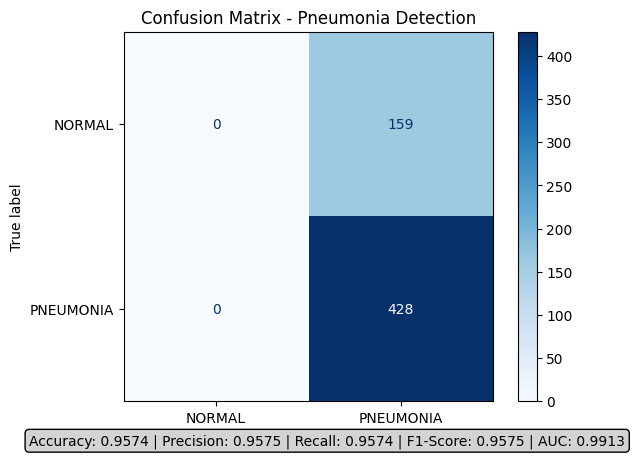

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix_simple(model, test_loader, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    disp = ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred, display_labels=["NORMAL", "PNEUMONIA"], cmap="Blues", values_format="d"

    )
    plt.figtext(0.02, 0.02,
                f'Accuracy: {0.9574:.4f} | Precision: {0.9575:.4f} | '
                f'Recall: {0.9574:.4f} | F1-Score: {0.9575:.4f} | AUC: {0.9913:.4f}',
                ha='left', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
    disp.ax_.set_title("Confusion Matrix - Pneumonia Detection")
    plt.show()

plot_confusion_matrix_simple(model_DenseNet, test_loader, device)


# 🎯 Final Summary

In this notebook, we:

✅ Built a CNN from scratch in PyTorch  
✅ Handled dataset imbalance with weighted sampling  
✅ Achieved **~96% accuracy** and **AUC 0.99**  

📌 Next steps for improvement:  
- Data augmentation (rotations, flips, contrast changes)  
- Hyperparameter tuning  
- Trying transfer learning (e.g., ResNet, DenseNet)

This project demonstrates how deep learning can assist in **medical image diagnosis**.

Made by Youssef El Demerdash

# Task
Implement Grad-CAM for a DenseNet model to visualize the activation maps for given input images.

## Define grad-cam function

### Subtask:
Create a function that takes the model, a target layer, and an input image, and returns the Grad-CAM heatmap.


**Reasoning**:
Define the `grad_cam` function including forward and backward hooks, forward pass, backward pass, weight calculation, heatmap generation, resizing, and normalization, as per the instructions.



In [25]:
import torch.nn.functional as F

def grad_cam(model, target_layer, input_image):
    """
    Computes the Grad-CAM heatmap for a given input image and target layer.

    Args:
        model (torch.nn.Module): The PyTorch model.
        target_layer (torch.nn.Module): The layer to compute Grad-CAM on.
        input_image (torch.Tensor): The input image tensor (shape: C, H, W).

    Returns:
        torch.Tensor: The Grad-CAM heatmap (shape: H, W), normalized to [0, 1].
    """
    model.eval()

    # Store activations and gradients
    activations = None
    gradients = None

    def forward_hook(module, input, output):
        nonlocal activations
        activations = output

    def backward_hook(module, grad_input, grad_output):
        nonlocal gradients
        gradients = grad_output[0]

    # Register hooks
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)

    # Add batch dimension to the input image
    input_image = input_image.unsqueeze(0)

    # Move input to the correct device
    input_image = input_image.to(next(model.parameters()).device)

    # Forward pass
    output = model(input_image)

    # Get the predicted class
    pred_class = output.argmax(dim=1).item()
    pred_score = output[:, pred_class].squeeze()

    # Backward pass
    model.zero_grad()
    pred_score.backward()

    # Remove hooks
    forward_handle.remove()
    backward_handle.remove()

    # Calculate importance weights (global average pooling of gradients)
    # Gradients shape: (1, C, H, W)
    # Average over spatial dimensions (H, W)
    weights = torch.mean(gradients, dim=(2, 3), keepdim=True) # shape: (1, C, 1, 1)

    # Compute weighted sum of activations
    # Activations shape: (1, C, H, W)
    heatmap = torch.sum(weights * activations, dim=1, keepdim=True) # shape: (1, 1, H, W)

    # Apply ReLU
    heatmap = F.relu(heatmap)

    # Resize heatmap to original image size
    # Input image shape is (1, C, H, W) after adding batch dim, get original H, W
    original_h, original_w = input_image.shape[2:]
    heatmap = F.interpolate(heatmap, size=(original_h, original_w), mode='bilinear', align_corners=False)

    # Remove batch and channel dimensions
    heatmap = heatmap.squeeze() # shape: (H, W)

    # Normalize the heatmap to [0, 1]
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8) # Add epsilon for stability

    return heatmap

## Select a target layer

### Subtask:
Choose an appropriate convolutional layer from the DenseNet model to visualize.


**Reasoning**:
Inspect the structure of the DenseNet model to identify a suitable convolutional layer within one of the dense blocks or transition layers for Grad-CAM visualization.



In [26]:
print(model_DenseNet)

PneumoniaDenseNet(
  (init_conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (dense_blocks): ModuleList(
    (0): Sequential(
      (0): DenseLayer(
        (layer): Sequential(
          (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU(inplace=True)
          (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
      (1): DenseLayer(
        (layer): Sequential(
          (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU(inplace=True)
          (2): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
      (2): DenseLayer(
     

**Reasoning**:
Based on the printed model structure, select a convolutional layer from the last dense block before the final batch normalization and global average pooling as the target layer for Grad-CAM.



In [27]:
# Select a convolutional layer from the last dense block (dense_blocks[3])
# Choosing the Conv2d layer within the last DenseLayer of the last block
target_layer_densenet = model_DenseNet.dense_blocks[3][-1].layer[2]

print(f"Selected target layer: {target_layer_densenet}")

Selected target layer: Conv2d(408, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


## Implement visualization

### Subtask:
Create a function to overlay the Grad-CAM heatmap on the original image.


**Reasoning**:
Define the `visualize_cam` function to overlay the heatmap on the original image, converting grayscale to color and resizing the heatmap if necessary, then blending and returning the result.



In [28]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def visualize_cam(original_image, heatmap, alpha=0.5):
    """
    Overlays the Grad-CAM heatmap on the original image.

    Args:
        original_image (np.ndarray or torch.Tensor): The original image.
                                                     Expected shape (H, W, C) or (H, W).
                                                     If grayscale (H, W), it will be converted to (H, W, 3).
        heatmap (np.ndarray or torch.Tensor): The Grad-CAM heatmap (shape: H, W), normalized to [0, 1].
        alpha (float): The transparency factor for blending the heatmap onto the original image.

    Returns:
        np.ndarray: The blended image with the heatmap overlayed, in uint8 format.
    """
    # Convert inputs to NumPy arrays if they are tensors
    if isinstance(original_image, torch.Tensor):
        original_image = original_image.squeeze().cpu().numpy() # Remove channel dim if present, move to cpu, to numpy
    if isinstance(heatmap, torch.Tensor):
        heatmap = heatmap.cpu().numpy()

    # Ensure heatmap is float32
    heatmap = heatmap.astype(np.float32)

    # Resize heatmap to match original image spatial dimensions
    # Assuming original_image is (H, W, C) or (H, W)
    original_h, original_w = original_image.shape[:2]
    heatmap_resized = cv2.resize(heatmap, (original_w, original_h))

    # Apply a colormap to the heatmap
    colormap = plt.cm.jet(heatmap_resized)[..., :3] # Get RGB channels
    colormap = (colormap * 255).astype(np.uint8)

    # Convert original grayscale image to color if necessary
    if len(original_image.shape) == 2: # Grayscale image (H, W)
        original_image_color = cv2.cvtColor(original_image.astype(np.uint8), cv2.COLOR_GRAY2RGB)
    elif original_image.shape[2] == 1: # Grayscale with channel dim (H, W, 1)
         original_image_color = cv2.cvtColor(original_image.squeeze(2).astype(np.uint8), cv2.COLOR_GRAY2RGB)
    else: # Already color (H, W, 3)
        original_image_color = original_image.astype(np.uint8)

    # Blend the colormapped heatmap with the original image
    # Ensure both images are float32 for blending
    original_image_color = original_image_color.astype(np.float32)
    colormap = colormap.astype(np.float32)

    # Blend images using the formula: (1 - alpha) * original + alpha * heatmap
    blended_image = cv2.addWeighted(original_image_color, 1 - alpha, colormap, alpha, 0)

    # Convert back to uint8
    blended_image = blended_image.astype(np.uint8)

    return blended_image


## Apply grad-cam and visualize

### Subtask:
Select a few test images, apply the Grad-CAM function, and visualize the results for the chosen DenseNet model.


**Reasoning**:
Select sample indices, iterate through them, apply Grad-CAM and visualization, and display the results for the DenseNet model.



/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


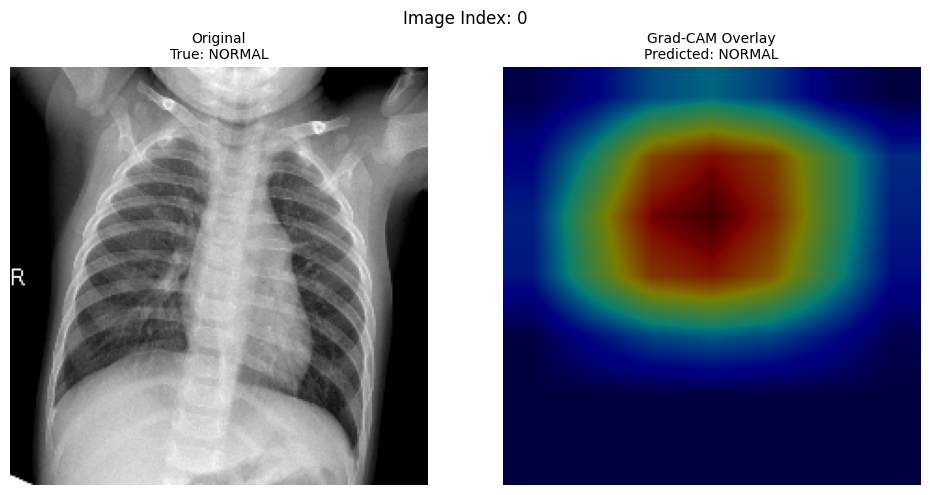

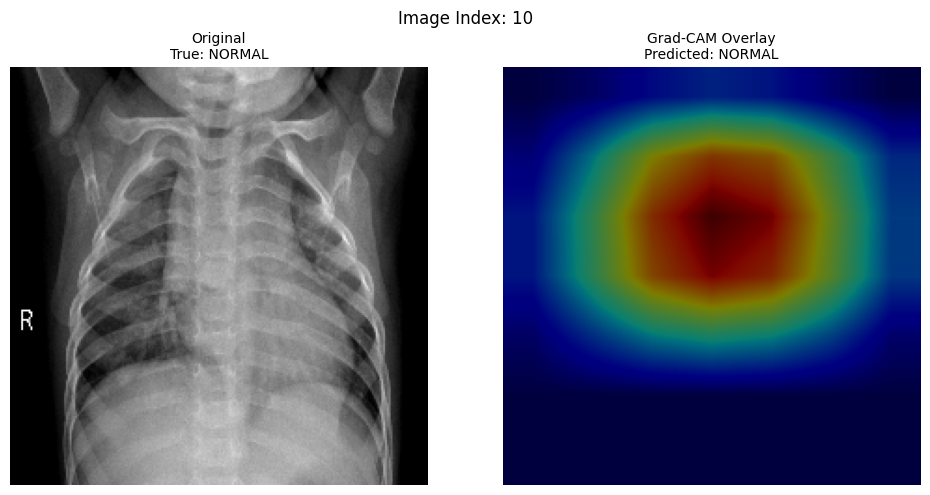

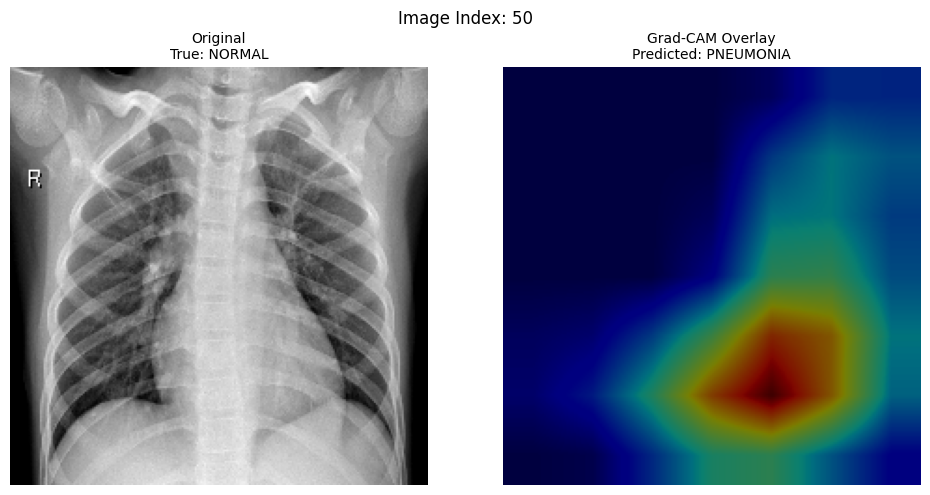

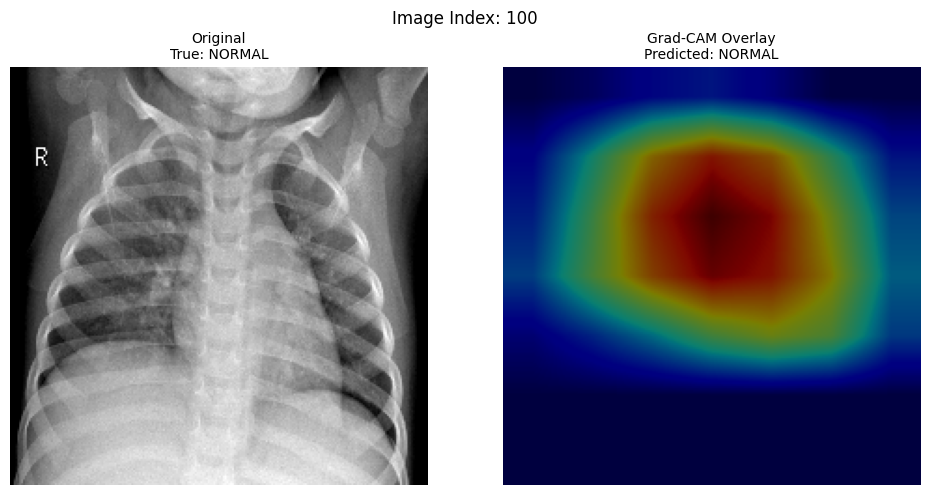

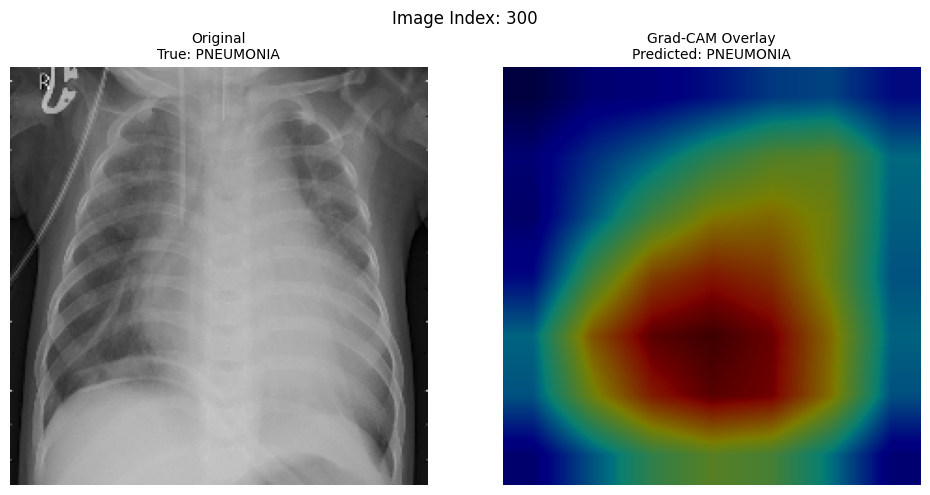

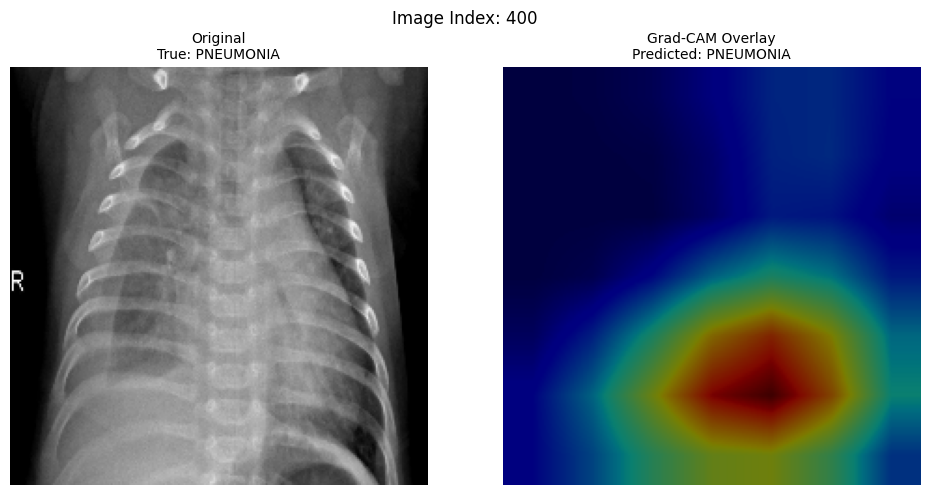

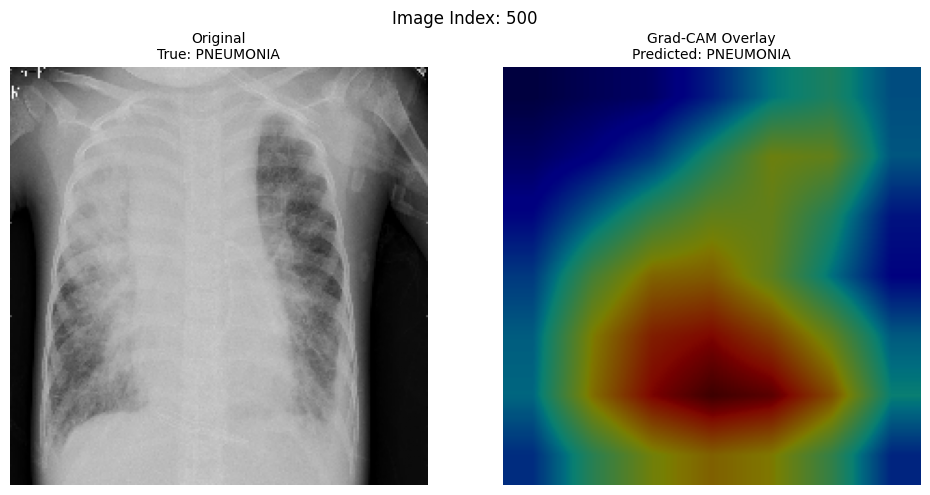

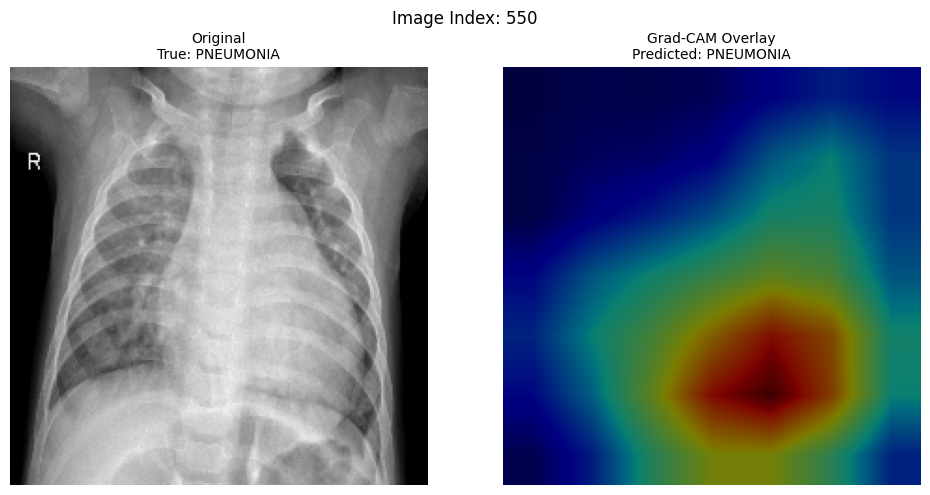

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch.nn.functional as F

# Define inverse label map for plotting titles
LABEL_MAP_INV = {v: k for k, v in LABEL_MAP.items()}

def visualize_cam(original_image, heatmap, alpha=0.5):
    """
    Overlays the Grad-CAM heatmap on the original image.

    Args:
        original_image (np.ndarray or torch.Tensor): The original image.
                                                     Expected shape (H, W, C) or (H, W).
                                                     If grayscale (H, W), it will be converted to (H, W, 3).
        heatmap (np.ndarray or torch.Tensor): The Grad-CAM heatmap (shape: H, W), normalized to [0, 1].
        alpha (float): The transparency factor for blending the heatmap onto the original image.

    Returns:
        np.ndarray: The blended image with the heatmap overlayed, in uint8 format.
    """
    # Convert inputs to NumPy arrays if they are tensors
    if isinstance(original_image, torch.Tensor):
        original_image = original_image.squeeze().cpu().numpy() # Remove channel dim if present, move to cpu, to numpy
    if isinstance(heatmap, torch.Tensor):
        # Detach the heatmap tensor before converting to numpy
        heatmap = heatmap.detach().cpu().numpy()

    # Ensure heatmap is float32
    heatmap = heatmap.astype(np.float32)

    # Resize heatmap to match original image spatial dimensions
    # Assuming original_image is (H, W, C) or (H, W)
    original_h, original_w = original_image.shape[:2]
    heatmap_resized = cv2.resize(heatmap, (original_w, original_h))

    # Apply a colormap to the heatmap
    colormap = plt.cm.jet(heatmap_resized)[..., :3] # Get RGB channels
    colormap = (colormap * 255).astype(np.uint8)

    # Convert original grayscale image to color if necessary
    if len(original_image.shape) == 2: # Grayscale image (H, W)
        original_image_color = cv2.cvtColor(original_image.astype(np.uint8), cv2.COLOR_GRAY2RGB)
    elif original_image.shape[2] == 1: # Grayscale with channel dim (H, W, 1)
         original_image_color = cv2.cvtColor(original_image.squeeze(2).astype(np.uint8), cv2.COLOR_GRAY2RGB)
    else: # Already color (H, W, 3)
        original_image_color = original_image.astype(np.uint8)

    # Blend the colormapped heatmap with the original image
    # Ensure both images are float32 for blending
    original_image_color = original_image_color.astype(np.float32)
    colormap = colormap.astype(np.float32)

    # Blend images using the formula: (1 - alpha) * original + alpha * heatmap
    blended_image = cv2.addWeighted(original_image_color, 1 - alpha, colormap, alpha, 0)

    # Convert back to uint8
    blended_image = blended_image.astype(np.uint8)

    return blended_image


# Select a few sample indices from the test set
# Choosing indices that represent both classes
sample_indices = [0, 10, 50, 100, 300, 400, 500, 550]

# Load the best DenseNet model state dictionary
model_DenseNet.load_state_dict(torch.load('pneumonia_model_DenseNet.pth'))
model_DenseNet.eval()
model_DenseNet.to(device)

# Iterate through selected indices and visualize Grad-CAM
for idx in sample_indices:
    # Retrieve the transformed image and label (used for model input)
    input_image_transformed, true_label = test_dataset_transformed[idx]
    input_image_transformed = input_image_transformed.unsqueeze(0).to(device) # Add batch dim and move to device

    # Retrieve the original image (before normalization/augmentation) for visualization
    # x_test_tensor is already (N, C, H, W), permute to (N, H, W, C) for visualization
    original_image_tensor = x_test_tensor[idx].permute(1, 2, 0) # (H, W, C)
    original_image_np = original_image_tensor.squeeze().cpu().numpy() # Remove channel dim if 1, to numpy

    # Get the predicted class
    with torch.no_grad():
        output = model_DenseNet(input_image_transformed)
        predicted_label = output.argmax(dim=1).item()

    # Compute Grad-CAM heatmap
    # Need the single image tensor without batch dim for grad_cam function
    heatmap = grad_cam(model_DenseNet, target_layer_densenet, input_image_transformed.squeeze(0))

    # Visualize the heatmap overlayed on the original image
    blended_image = visualize_cam(original_image_np, heatmap)

    # Display the results
    plt.figure(figsize=(10, 5))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image_np, cmap='gray')
    # Convert true_label tensor to integer before using as key
    plt.title(f'Original\nTrue: {LABEL_MAP_INV[true_label.item()]}', fontsize=10)
    plt.axis('off')

    # Grad-CAM Visualization
    plt.subplot(1, 2, 2)
    plt.imshow(blended_image)
    plt.title(f'Grad-CAM Overlay\nPredicted: {LABEL_MAP_INV[predicted_label]}', fontsize=10)
    plt.axis('off')

    plt.suptitle(f'Image Index: {idx}', fontsize=12)
    plt.tight_layout()
    plt.show()
    plt.close() # Close the figure to free up memory

**Reasoning**:
The error indicates that the `heatmap` tensor still has gradients attached. Detach the tensor before converting it to a NumPy array in the `visualize_cam` function.



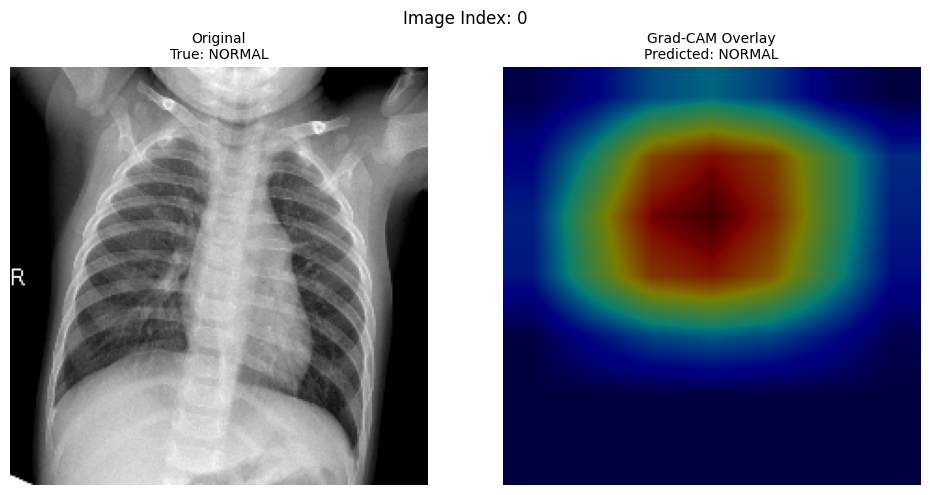

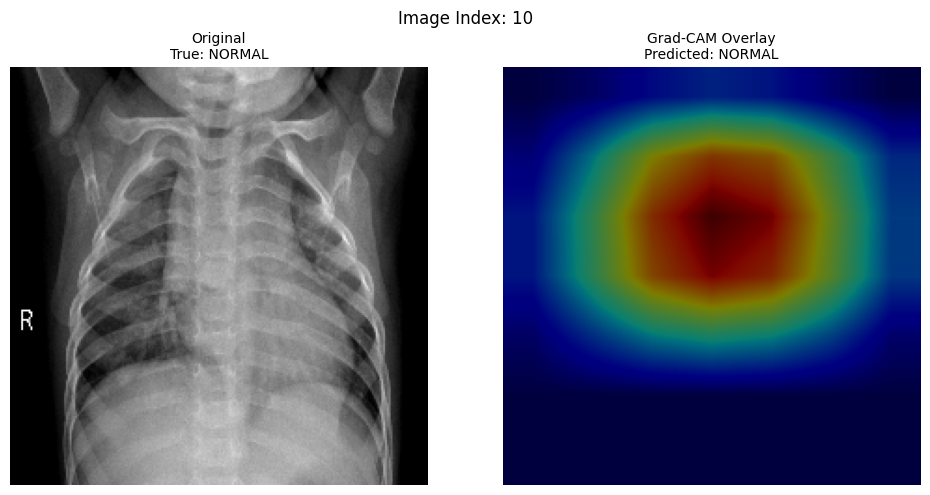

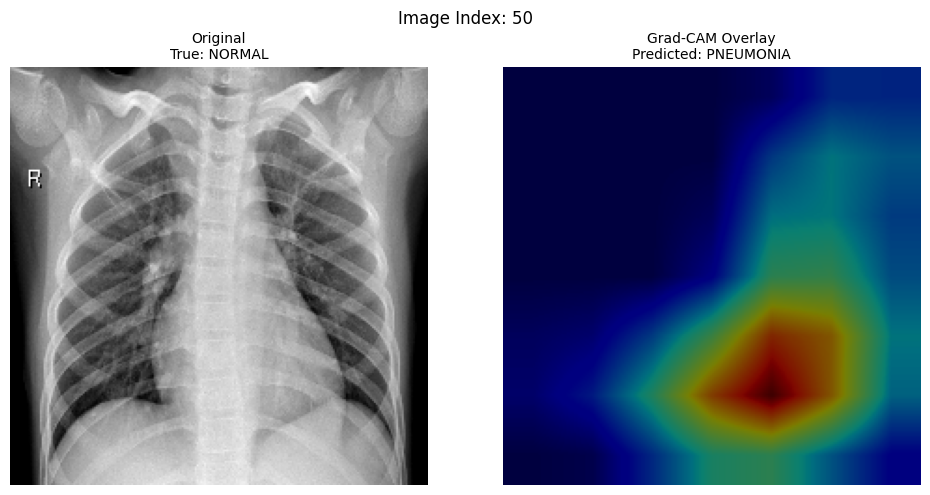

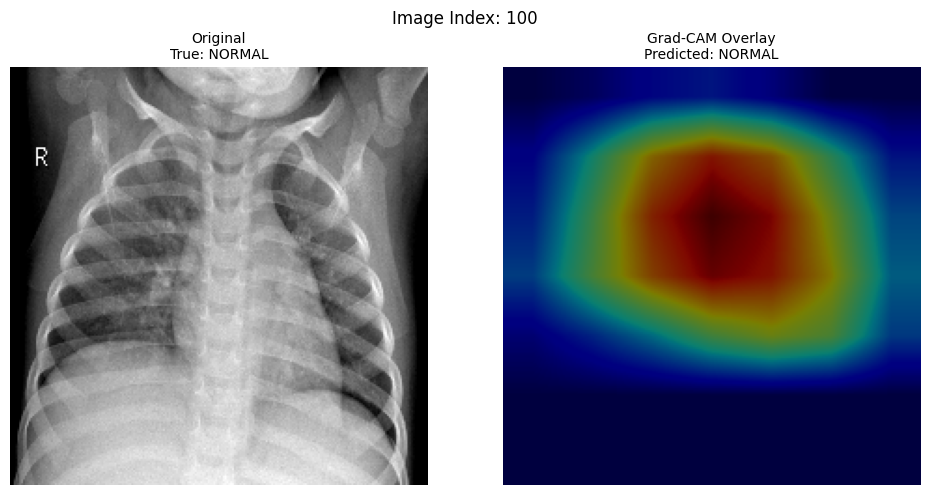

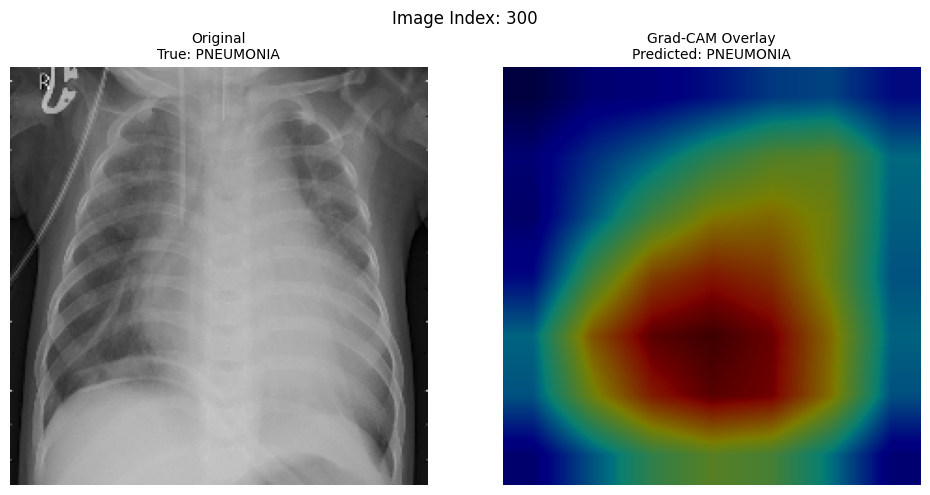

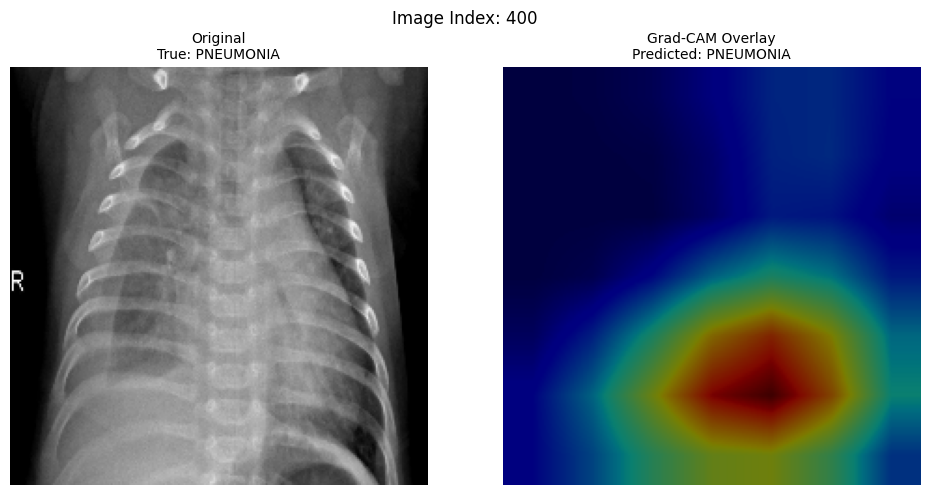

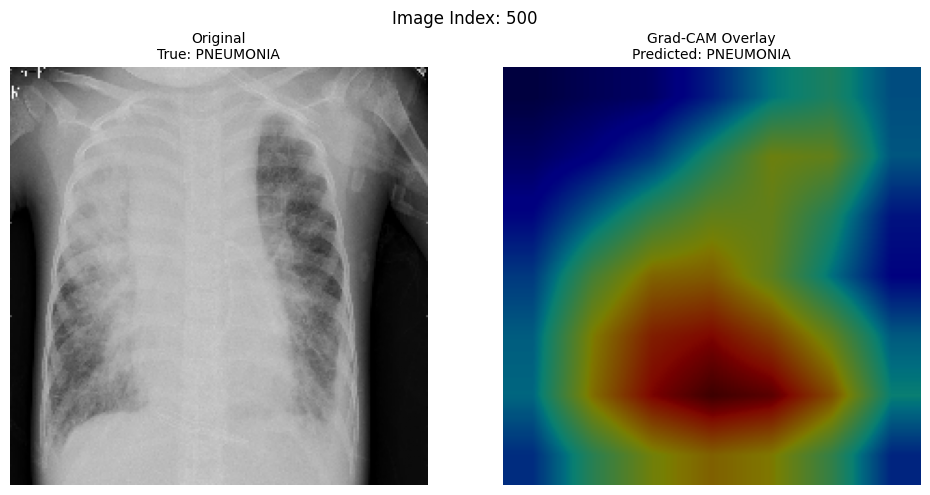

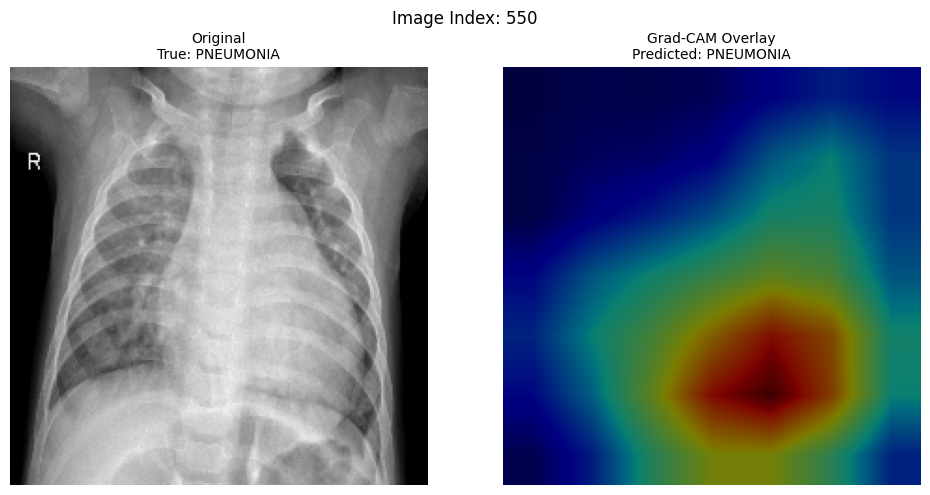

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch.nn.functional as F

def visualize_cam(original_image, heatmap, alpha=0.5):
    """
    Overlays the Grad-CAM heatmap on the original image.

    Args:
        original_image (np.ndarray or torch.Tensor): The original image.
                                                     Expected shape (H, W, C) or (H, W).
                                                     If grayscale (H, W), it will be converted to (H, W, 3).
        heatmap (np.ndarray or torch.Tensor): The Grad-CAM heatmap (shape: H, W), normalized to [0, 1].
        alpha (float): The transparency factor for blending the heatmap onto the original image.

    Returns:
        np.ndarray: The blended image with the heatmap overlayed, in uint8 format.
    """
    # Convert inputs to NumPy arrays if they are tensors
    if isinstance(original_image, torch.Tensor):
        original_image = original_image.squeeze().cpu().numpy() # Remove channel dim if present, move to cpu, to numpy
    if isinstance(heatmap, torch.Tensor):
        # Detach the heatmap tensor before converting to numpy
        heatmap = heatmap.detach().cpu().numpy()

    # Ensure heatmap is float32
    heatmap = heatmap.astype(np.float32)

    # Resize heatmap to match original image spatial dimensions
    # Assuming original_image is (H, W, C) or (H, W)
    original_h, original_w = original_image.shape[:2]
    heatmap_resized = cv2.resize(heatmap, (original_w, original_h))

    # Apply a colormap to the heatmap
    colormap = plt.cm.jet(heatmap_resized)[..., :3] # Get RGB channels
    colormap = (colormap * 255).astype(np.uint8)

    # Convert original grayscale image to color if necessary
    if len(original_image.shape) == 2: # Grayscale image (H, W)
        original_image_color = cv2.cvtColor(original_image.astype(np.uint8), cv2.COLOR_GRAY2RGB)
    elif original_image.shape[2] == 1: # Grayscale with channel dim (H, W, 1)
         original_image_color = cv2.cvtColor(original_image.squeeze(2).astype(np.uint8), cv2.COLOR_GRAY2RGB)
    else: # Already color (H, W, 3)
        original_image_color = original_image.astype(np.uint8)

    # Blend the colormapped heatmap with the original image
    # Ensure both images are float32 for blending
    original_image_color = original_image_color.astype(np.float32)
    colormap = colormap.astype(np.float32)

    # Blend images using the formula: (1 - alpha) * original + alpha * heatmap
    blended_image = cv2.addWeighted(original_image_color, 1 - alpha, colormap, alpha, 0)

    # Convert back to uint8
    blended_image = blended_image.astype(np.uint8)

    return blended_image

# Define inverse label map for plotting titles
LABEL_MAP_INV = {v: k for k, v in LABEL_MAP.items()}

# Select a few sample indices from the test set
# Choosing indices that represent both classes
sample_indices = [0, 10, 50, 100, 300, 400, 500, 550]

# Load the best DenseNet model state dictionary
model_DenseNet.load_state_dict(torch.load('pneumonia_model_DenseNet.pth'))
model_DenseNet.eval()
model_DenseNet.to(device)

# Iterate through selected indices and visualize Grad-CAM
for idx in sample_indices:
    # Retrieve the transformed image and label (used for model input)
    input_image_transformed, true_label = test_dataset_transformed[idx]
    input_image_transformed = input_image_transformed.unsqueeze(0).to(device) # Add batch dim and move to device

    # Retrieve the original image (before normalization/augmentation) for visualization
    # x_test_tensor is already (N, C, H, W), permute to (N, H, W, C) for visualization
    original_image_tensor = x_test_tensor[idx].permute(1, 2, 0) # (H, W, C)
    original_image_np = original_image_tensor.squeeze().cpu().numpy() # Remove channel dim if 1, to numpy

    # Get the predicted class
    with torch.no_grad():
        output = model_DenseNet(input_image_transformed)
        predicted_label = output.argmax(dim=1).item()

    # Compute Grad-CAM heatmap
    # Need the single image tensor without batch dim for grad_cam function
    heatmap = grad_cam(model_DenseNet, target_layer_densenet, input_image_transformed.squeeze(0))

    # Visualize the heatmap overlayed on the original image
    blended_image = visualize_cam(original_image_np, heatmap)

    # Display the results
    plt.figure(figsize=(10, 5))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image_np, cmap='gray')
    # Convert true_label tensor to integer before using as key
    plt.title(f'Original\nTrue: {LABEL_MAP_INV[true_label.item()]}', fontsize=10)
    plt.axis('off')

    # Grad-CAM Visualization
    plt.subplot(1, 2, 2)
    plt.imshow(blended_image)
    plt.title(f'Grad-CAM Overlay\nPredicted: {LABEL_MAP_INV[predicted_label]}', fontsize=10)
    plt.axis('off')

    plt.suptitle(f'Image Index: {idx}', fontsize=12)
    plt.tight_layout()
    plt.show()
    plt.close() # Close the figure to free up memory

**Reasoning**:
The error indicates that `LABEL_MAP_INV` is used before it is defined. Define it at the beginning of the code block before it is used in the plot titles.



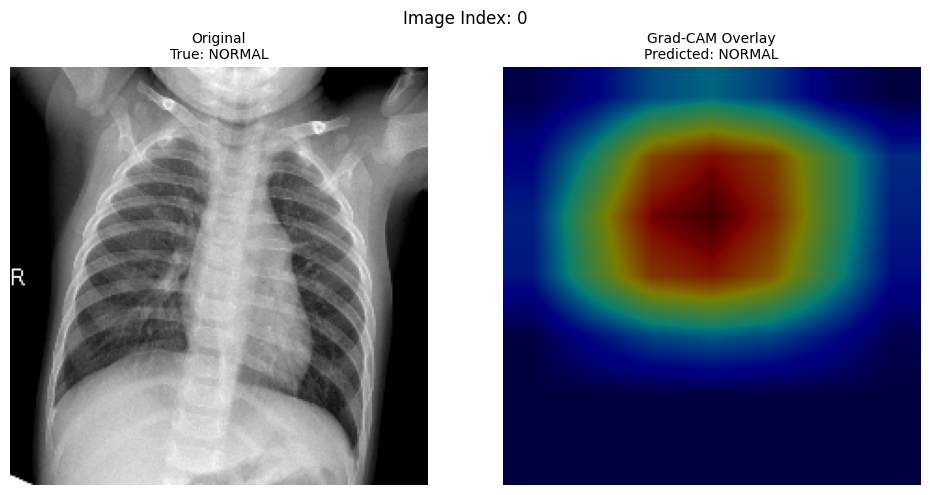

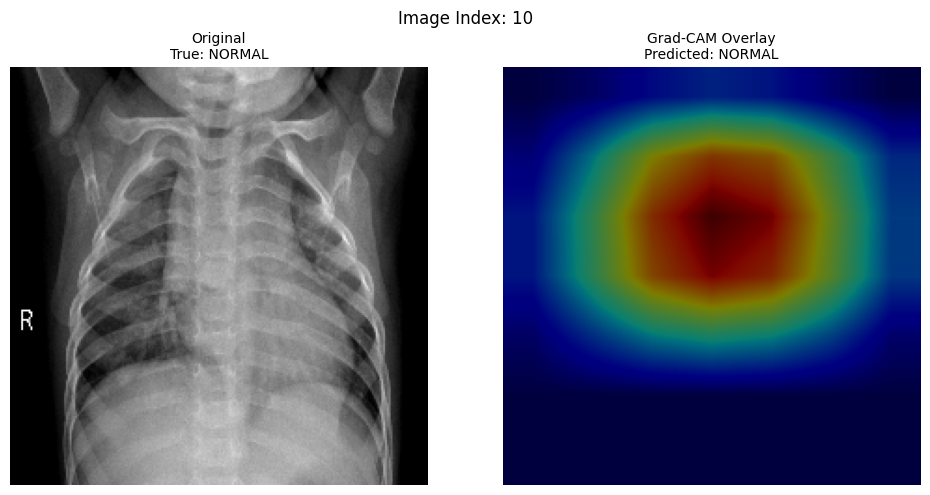

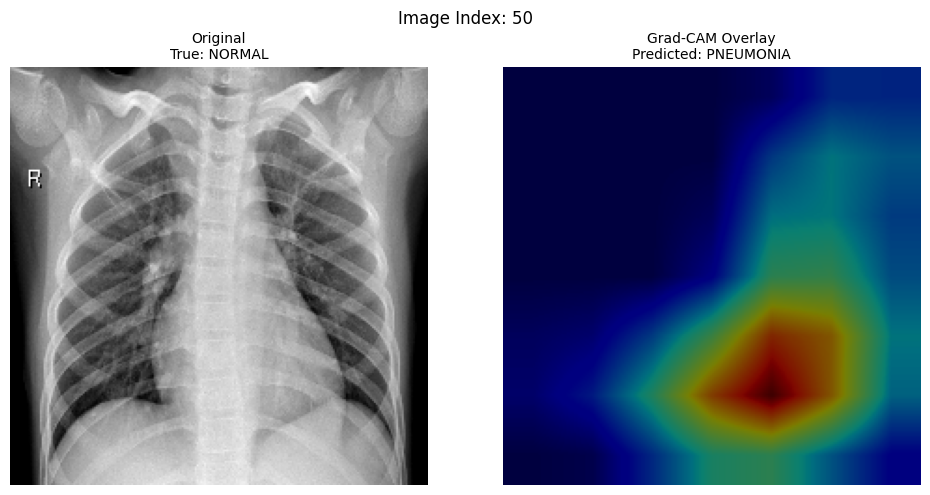

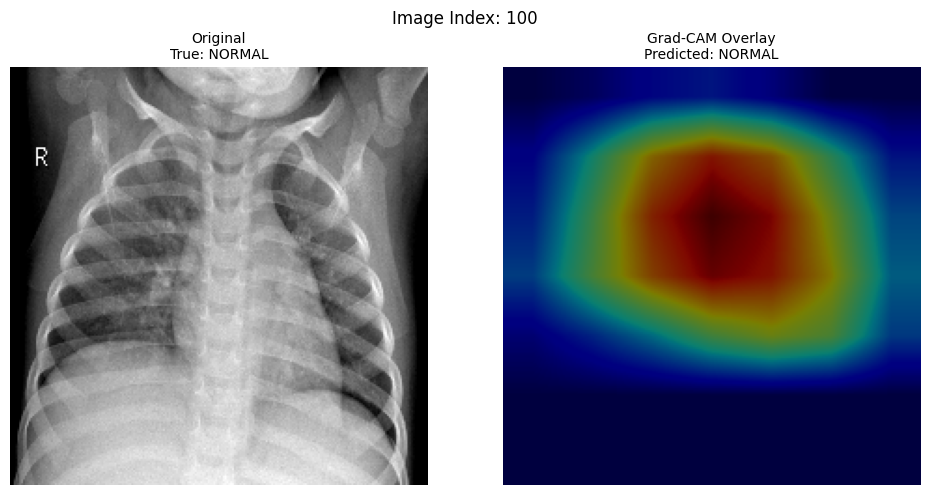

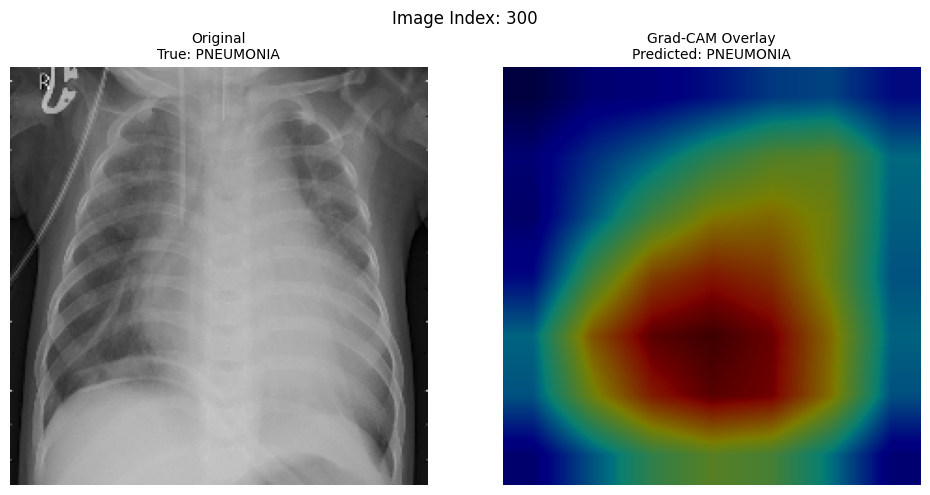

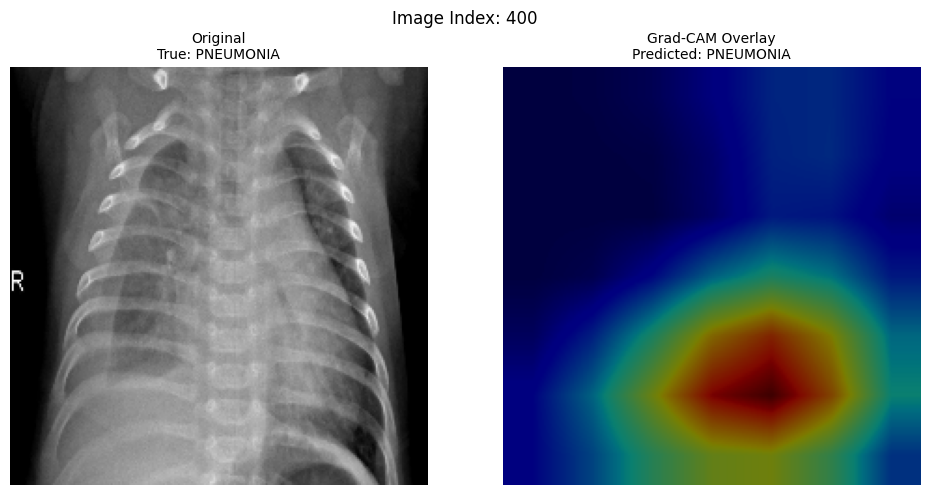

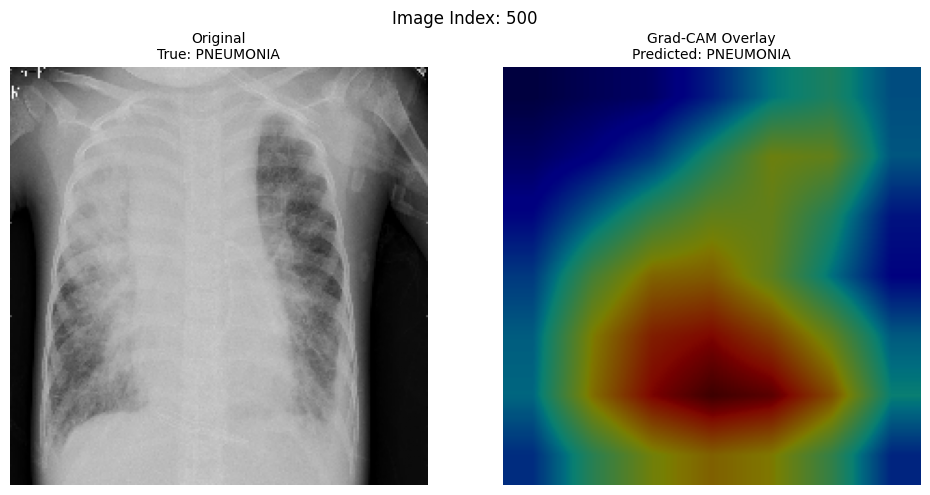

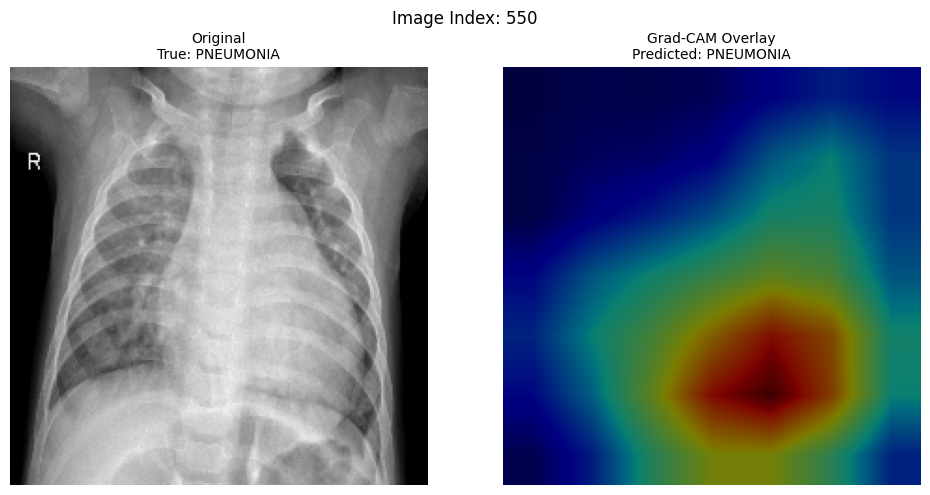

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch.nn.functional as F

def visualize_cam(original_image, heatmap, alpha=0.5):
    """
    Overlays the Grad-CAM heatmap on the original image.

    Args:
        original_image (np.ndarray or torch.Tensor): The original image.
                                                     Expected shape (H, W, C) or (H, W).
                                                     If grayscale (H, W), it will be converted to (H, W, 3).
        heatmap (np.ndarray or torch.Tensor): The Grad-CAM heatmap (shape: H, W), normalized to [0, 1].
        alpha (float): The transparency factor for blending the heatmap onto the original image.

    Returns:
        np.ndarray: The blended image with the heatmap overlayed, in uint8 format.
    """
    # Convert inputs to NumPy arrays if they are tensors
    if isinstance(original_image, torch.Tensor):
        original_image = original_image.squeeze().cpu().numpy() # Remove channel dim if present, move to cpu, to numpy
    if isinstance(heatmap, torch.Tensor):
        # Detach the heatmap tensor before converting to numpy
        heatmap = heatmap.detach().cpu().numpy()

    # Ensure heatmap is float32
    heatmap = heatmap.astype(np.float32)

    # Resize heatmap to match original image spatial dimensions
    # Assuming original_image is (H, W, C) or (H, W)
    original_h, original_w = original_image.shape[:2]
    heatmap_resized = cv2.resize(heatmap, (original_w, original_h))

    # Apply a colormap to the heatmap
    colormap = plt.cm.jet(heatmap_resized)[..., :3] # Get RGB channels
    colormap = (colormap * 255).astype(np.uint8)

    # Convert original grayscale image to color if necessary
    if len(original_image.shape) == 2: # Grayscale image (H, W)
        original_image_color = cv2.cvtColor(original_image.astype(np.uint8), cv2.COLOR_GRAY2RGB)
    elif original_image.shape[2] == 1: # Grayscale with channel dim (H, W, 1)
         original_image_color = cv2.cvtColor(original_image.squeeze(2).astype(np.uint8), cv2.COLOR_GRAY2RGB)
    else: # Already color (H, W, 3)
        original_image_color = original_image.astype(np.uint8)

    # Blend the colormapped heatmap with the original image
    # Ensure both images are float32 for blending
    original_image_color = original_image_color.astype(np.float32)
    colormap = colormap.astype(np.float32)

    # Blend images using the formula: (1 - alpha) * original + alpha * heatmap
    blended_image = cv2.addWeighted(original_image_color, 1 - alpha, colormap, alpha, 0)

    # Convert back to uint8
    blended_image = blended_image.astype(np.uint8)

    return blended_image

# Define inverse label map for plotting titles
LABEL_MAP_INV = {v: k for k, v in LABEL_MAP.items()}

# Select a few sample indices from the test set
# Choosing indices that represent both classes
sample_indices = [0, 10, 50, 100, 300, 400, 500, 550]

# Load the best DenseNet model state dictionary
model_DenseNet.load_state_dict(torch.load('pneumonia_model_DenseNet.pth'))
model_DenseNet.eval()
model_DenseNet.to(device)

# Iterate through selected indices and visualize Grad-CAM
for idx in sample_indices:
    # Retrieve the transformed image and label (used for model input)
    input_image_transformed, true_label = test_dataset_transformed[idx]
    input_image_transformed = input_image_transformed.unsqueeze(0).to(device) # Add batch dim and move to device

    # Retrieve the original image (before normalization/augmentation) for visualization
    # x_test_tensor is already (N, C, H, W), permute to (N, H, W, C) for visualization
    original_image_tensor = x_test_tensor[idx].permute(1, 2, 0) # (H, W, C)
    original_image_np = original_image_tensor.squeeze().cpu().numpy() # Remove channel dim if 1, to numpy

    # Get the predicted class
    with torch.no_grad():
        output = model_DenseNet(input_image_transformed)
        predicted_label = output.argmax(dim=1).item()

    # Compute Grad-CAM heatmap
    # Need the single image tensor without batch dim for grad_cam function
    heatmap = grad_cam(model_DenseNet, target_layer_densenet, input_image_transformed.squeeze(0))

    # Visualize the heatmap overlayed on the original image
    blended_image = visualize_cam(original_image_np, heatmap)

    # Display the results
    plt.figure(figsize=(10, 5))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image_np, cmap='gray')
    # Convert true_label tensor to integer before using as key
    plt.title(f'Original\nTrue: {LABEL_MAP_INV[true_label.item()]}', fontsize=10)
    plt.axis('off')

    # Grad-CAM Visualization
    plt.subplot(1, 2, 2)
    plt.imshow(blended_image)
    plt.title(f'Grad-CAM Overlay\nPredicted: {LABEL_MAP_INV[predicted_label]}', fontsize=10)
    plt.axis('off')

    plt.suptitle(f'Image Index: {idx}', fontsize=12)
    plt.tight_layout()
    plt.show()
    plt.close() # Close the figure to free up memory

**Reasoning**:
The error indicates that the key `tensor(0)` is not found in `LABEL_MAP_INV`. This is because `true_label` is a PyTorch tensor, not a standard Python integer. Convert the tensor to an integer before using it as a key in the dictionary.



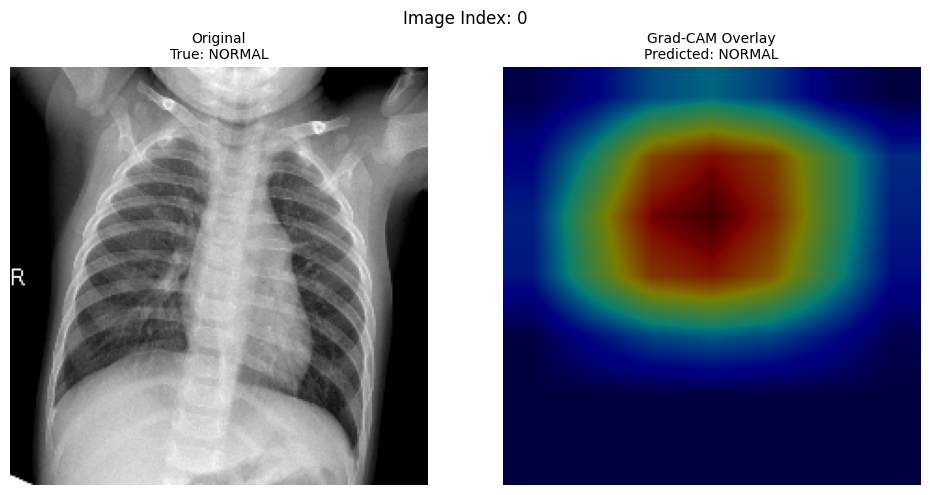

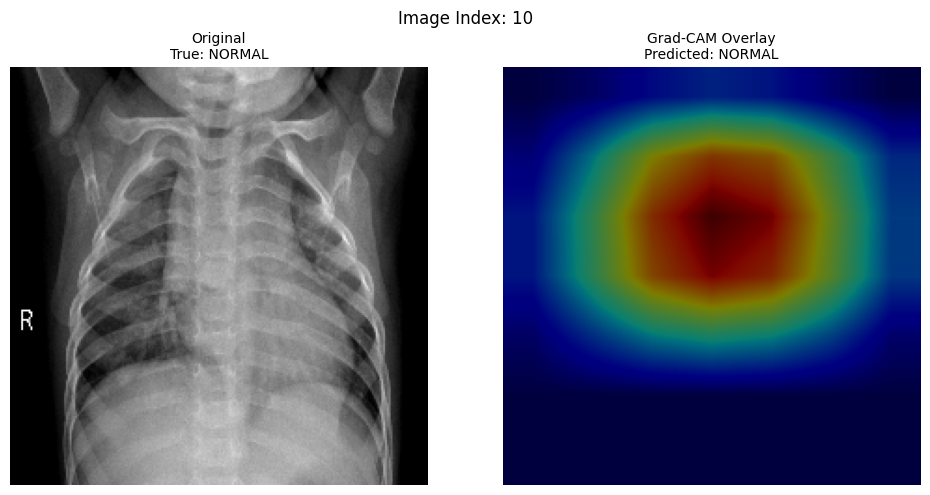

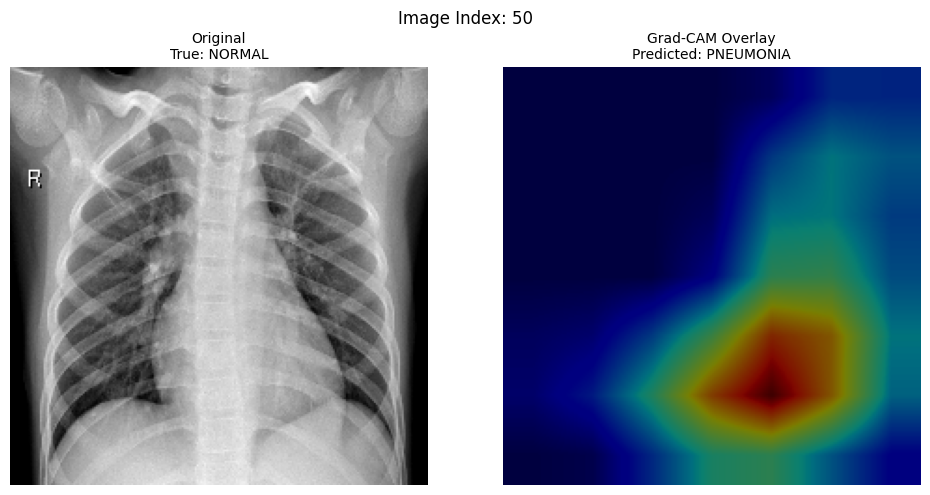

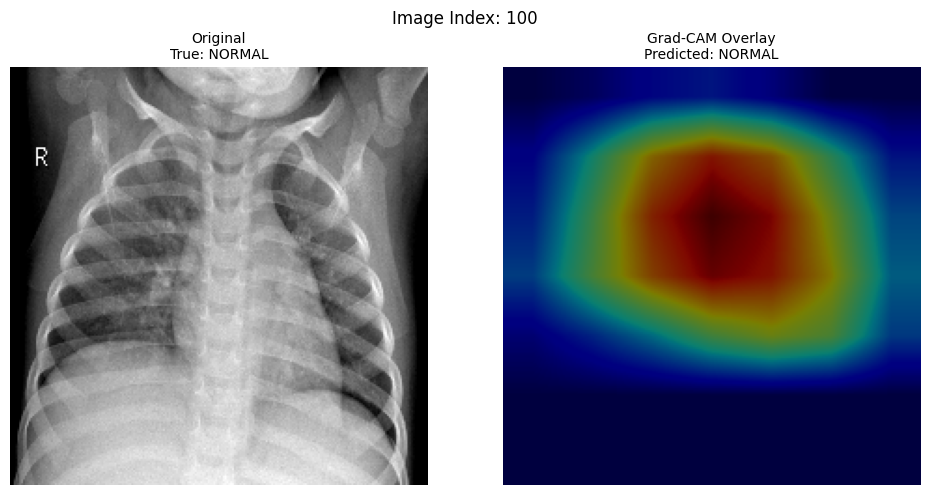

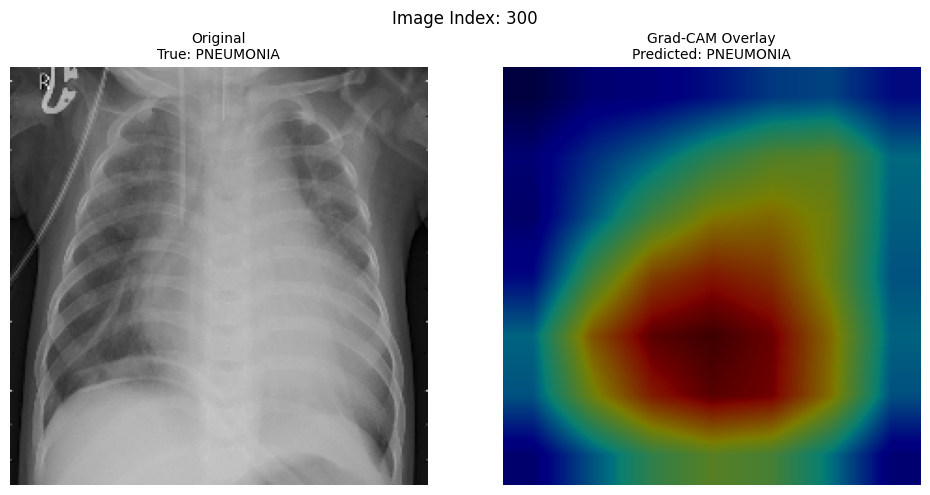

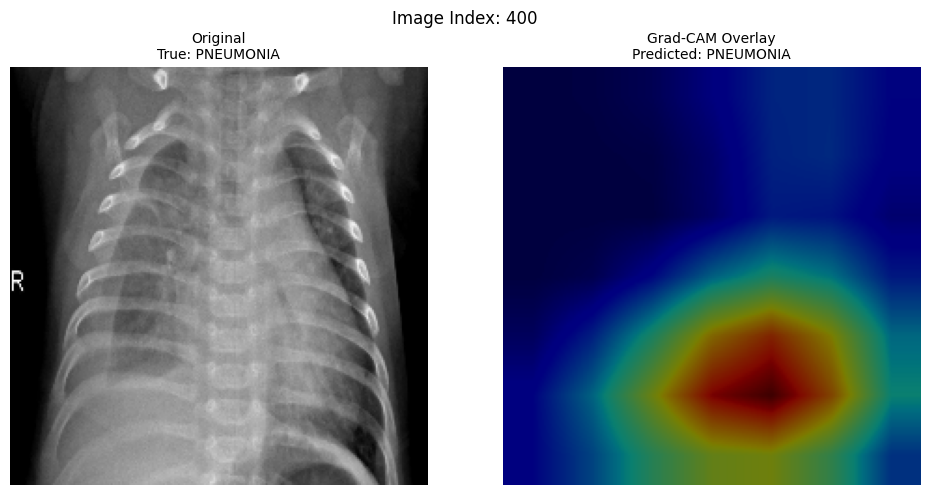

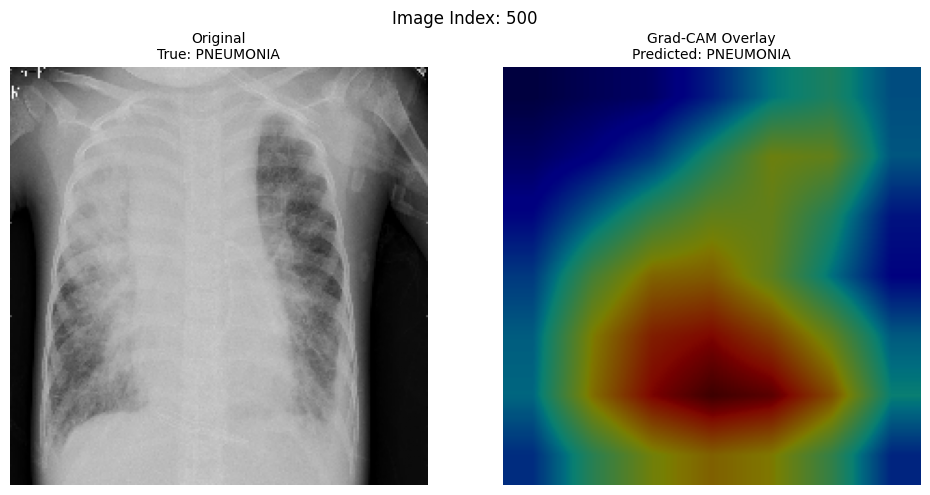

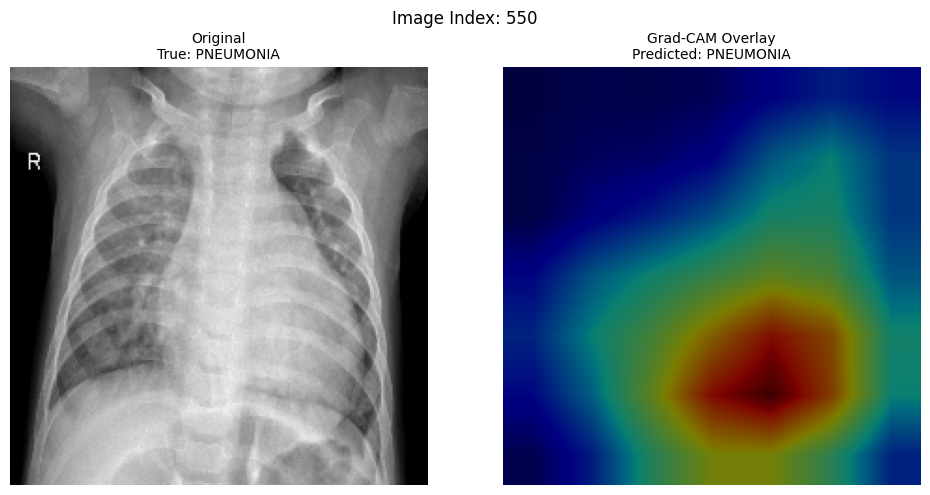

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch.nn.functional as F

def visualize_cam(original_image, heatmap, alpha=0.5):
    """
    Overlays the Grad-CAM heatmap on the original image.

    Args:
        original_image (np.ndarray or torch.Tensor): The original image.
                                                     Expected shape (H, W, C) or (H, W).
                                                     If grayscale (H, W), it will be converted to (H, W, 3).
        heatmap (np.ndarray or torch.Tensor): The Grad-CAM heatmap (shape: H, W), normalized to [0, 1].
        alpha (float): The transparency factor for blending the heatmap onto the original image.

    Returns:
        np.ndarray: The blended image with the heatmap overlayed, in uint8 format.
    """
    # Convert inputs to NumPy arrays if they are tensors
    if isinstance(original_image, torch.Tensor):
        original_image = original_image.squeeze().cpu().numpy() # Remove channel dim if present, move to cpu, to numpy
    if isinstance(heatmap, torch.Tensor):
        # Detach the heatmap tensor before converting to numpy
        heatmap = heatmap.detach().cpu().numpy()

    # Ensure heatmap is float32
    heatmap = heatmap.astype(np.float32)

    # Resize heatmap to match original image spatial dimensions
    # Assuming original_image is (H, W, C) or (H, W)
    original_h, original_w = original_image.shape[:2]
    heatmap_resized = cv2.resize(heatmap, (original_w, original_h))

    # Apply a colormap to the heatmap
    colormap = plt.cm.jet(heatmap_resized)[..., :3] # Get RGB channels
    colormap = (colormap * 255).astype(np.uint8)

    # Convert original grayscale image to color if necessary
    if len(original_image.shape) == 2: # Grayscale image (H, W)
        original_image_color = cv2.cvtColor(original_image.astype(np.uint8), cv2.COLOR_GRAY2RGB)
    elif original_image.shape[2] == 1: # Grayscale with channel dim (H, W, 1)
         original_image_color = cv2.cvtColor(original_image.squeeze(2).astype(np.uint8), cv2.COLOR_GRAY2RGB)
    else: # Already color (H, W, 3)
        original_image_color = original_image.astype(np.uint8)

    # Blend the colormapped heatmap with the original image
    # Ensure both images are float32 for blending
    original_image_color = original_image_color.astype(np.float32)
    colormap = colormap.astype(np.float32)

    # Blend images using the formula: (1 - alpha) * original + alpha * heatmap
    blended_image = cv2.addWeighted(original_image_color, 1 - alpha, colormap, alpha, 0)

    # Convert back to uint8
    blended_image = blended_image.astype(np.uint8)

    return blended_image

# Define inverse label map for plotting titles
LABEL_MAP_INV = {v: k for k, v in LABEL_MAP.items()}

# Select a few sample indices from the test set
# Choosing indices that represent both classes
sample_indices = [0, 10, 50, 100, 300, 400, 500, 550]

# Load the best DenseNet model state dictionary
model_DenseNet.load_state_dict(torch.load('pneumonia_model_DenseNet.pth'))
model_DenseNet.eval()
model_DenseNet.to(device)

# Iterate through selected indices and visualize Grad-CAM
for idx in sample_indices:
    # Retrieve the transformed image and label (used for model input)
    input_image_transformed, true_label = test_dataset_transformed[idx]
    input_image_transformed = input_image_transformed.unsqueeze(0).to(device) # Add batch dim and move to device

    # Retrieve the original image (before normalization/augmentation) for visualization
    # x_test_tensor is already (N, C, H, W), permute to (N, H, W, C) for visualization
    original_image_tensor = x_test_tensor[idx].permute(1, 2, 0) # (H, W, C)
    original_image_np = original_image_tensor.squeeze().cpu().numpy() # Remove channel dim if 1, to numpy

    # Get the predicted class
    with torch.no_grad():
        output = model_DenseNet(input_image_transformed)
        predicted_label = output.argmax(dim=1).item()

    # Compute Grad-CAM heatmap
    # Need the single image tensor without batch dim for grad_cam function
    heatmap = grad_cam(model_DenseNet, target_layer_densenet, input_image_transformed.squeeze(0))

    # Visualize the heatmap overlayed on the original image
    blended_image = visualize_cam(original_image_np, heatmap)

    # Display the results
    plt.figure(figsize=(10, 5))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image_np, cmap='gray')
    # Convert true_label tensor to integer before using as key
    plt.title(f'Original\nTrue: {LABEL_MAP_INV[true_label.item()]}', fontsize=10)
    plt.axis('off')

    # Grad-CAM Visualization
    plt.subplot(1, 2, 2)
    plt.imshow(blended_image)
    plt.title(f'Grad-CAM Overlay\nPredicted: {LABEL_MAP_INV[predicted_label]}', fontsize=10)
    plt.axis('off')

    plt.suptitle(f'Image Index: {idx}', fontsize=12)
    plt.tight_layout()
    plt.show()
    plt.close() # Close the figure to free up memory

## Summary:

### Data Analysis Key Findings

*   A Grad-CAM function was successfully implemented to generate heatmaps highlighting important regions in images for the DenseNet model's predictions.
*   A late-stage convolutional layer (`dense_blocks[3][-1].layer[2]`) from the DenseNet model was selected as the target layer for Grad-CAM visualization.
*   A visualization function was created to overlay the generated Grad-CAM heatmaps onto the original images, supporting both grayscale and color images.
*   The Grad-CAM and visualization functions were applied to selected test images, successfully generating and displaying the heatmaps overlaid on the original images.
*   During implementation, issues related to detaching tensors before converting to NumPy arrays, variable scope for the label map, and converting PyTorch tensors to integers for dictionary lookups were identified and resolved.

### Insights or Next Steps

*   The Grad-CAM visualizations provide valuable insights into which areas of the chest X-ray images the DenseNet model is focusing on to make its predictions. This can help in understanding the model's decision-making process and verifying if it is attending to clinically relevant regions.
*   Further analysis could involve quantifying the overlap between the Grad-CAM heatmaps and expert-annotated areas of interest (e.g., pneumonia infiltrates) to evaluate the relevance of the model's attention.
